# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
if not os.path.exists(os.path.join(DATA_PATH, 'pride_and_predjudice.txt')):
    os.chdir(BASE_PATH) 
    !cp pride_and_prejudice.txt /content
os.chdir('/content')

--2021-11-23 03:47:34--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  6.90MB/s    in 0.3s    

2021-11-23 03:47:34 (6.90 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # replace \n, \t with spaces
    data = " ".join(data.split())
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    print(voc2ind)
    print(ind2voc)

    split_index = int(len(data) * 0.8)
    train_text = data[:split_index]
    test_text = data[split_index:]

    train_pkl_path = data_path[len(DATA_PATH):-4] + '_chars_train.pkl'
    test_pkl_path = data_path[len(DATA_PATH):-4] + '_chars_test.pkl'
    print(train_pkl_path)
    print(test_pkl_path)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + train_pkl_path, 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + test_pkl_path, 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'H': 0, 'a': 1, 'r': 2, 'y': 3, ' ': 4, 'P': 5, 'o': 6, 't': 7, 'e': 8, 'n': 9, 'd': 10, 'h': 11, 'S': 12, 'c': 13, "'": 14, 's': 15, 'C': 16, 'A': 17, 'T': 18, 'E': 19, 'R': 20, 'O': 21, 'N': 22, 'B': 23, 'Y': 24, 'W': 25, 'L': 26, 'I': 27, 'V': 28, 'D': 29, 'M': 30, '.': 31, 'u': 32, 'l': 33, ',': 34, 'f': 35, 'm': 36, 'b': 37, 'i': 38, 'v': 39, 'w': 40, 'p': 41, 'k': 42, 'x': 43, 'g': 44, 'j': 45, 'G': 46, ';': 47, '-': 48, '"': 49, 'F': 50, 'z': 51, '?': 52, '!': 53, 'q': 54, 'K': 55, '(': 56, ')': 57, ':': 58, 'J': 59, 'U': 60, '4': 61, '1': 62, '7': 63, 'Z': 64, '3': 65, 'Q': 66, '~': 67, '0': 68, '2': 69, '8': 70, 'X': 71, '9': 72, '5': 73, '*': 74, '6': 75, '\\': 76, '/': 77, '`': 78, '_': 79, '=': 80, '$': 81, '%': 82, ']': 83, '&': 84, '}': 85, '^': 86, '{': 87, '[': 88}
{0: 'H', 1: 'a', 2: 'r', 3: 'y', 4: ' ', 5: 'P', 6: 'o', 7: 't', 8: 'e', 9: 'n', 10: 'd', 11: 'h', 12: 'S', 13: 'c', 14: "'", 15: 's', 16: 'C', 17: 'A', 18: 'T', 19: 'E', 20: 'R', 21: 'O', 22: 'N', 23: 'B', 

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        self.tokens = dataset['tokens']  # a string of words
        # "ABA CDBE" --> [1, 2, 1, 0, 3, 4, 2, 5]
        # want to split the encoded tokens into batch_size chunks
        encoded_tokens = torch.LongTensor([self.voc2ind[c] for c in self.tokens])
        self.chunks = encoded_tokens[:len(encoded_tokens) - len(encoded_tokens)%self.batch_size].view(self.batch_size, -1)
        # self.chunks.shape[0] == batch_size
        # self.chunks.shape[1] == chunk_size

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # len(one_chunk) = len(tokens) / batch_size
        # num_batch = ceil(len(one chunk) / sequence_length)
        chunk_size = self.chunks.shape[1]
        return self.batch_size * math.ceil(chunk_size / self.sequence_length)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        chunk_size = self.chunks.shape[1]
        batch_idx = idx % self.batch_size
        seq_start_idx = idx // self.batch_size * self.sequence_length
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, chunk_size)

        data = self.chunks[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [9]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        m = nn.ReLU()
        x = self.decoder(m(x))

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [10]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    # print("output shape:", output.shape)
    # print("sequence length:", sequence_length)
    # output shape: torch.Size([1, 89])
    # sequence length: 200
    for ii in range(sequence_length):
        # TODO
        max_idx = output[0].argmax()
        outputs.append(max_idx)
        output, hidden = model.inference(max_idx, hidden)

    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        random_idx = torch.multinomial(output[0], 1)[0]
        outputs.append(random_idx)
        output, hidden = model.inference(random_idx, hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    # print(output[0])
    '''
    tensor([1.6517e-01, 2.5057e-02, 1.1488e-03, 4.4171e-03, 2.2209e-07, 2.0459e-02,
        1.1283e-02, 3.9707e-03, 5.7665e-03, 2.4277e-03, 1.2907e-03, 6.1842e-03,
        3.4050e-02, 3.3461e-03, 7.2718e-03, 5.9175e-03, 1.0736e-02, 3.3752e-02,
        3.7023e-02, 2.8446e-03, 1.4617e-02, 1.4860e-02, 1.5890e-02, 1.6791e-02,
        9.2171e-03, 5.8036e-02, 8.5500e-03, 5.7428e-02, 1.2578e-03, 1.1423e-02,
        2.1873e-02, 4.5148e-02, 3.2809e-03, 1.2385e-03, 1.2515e-04, 1.6862e-03,
        4.0081e-03, 4.1718e-03, 4.4101e-03, 2.7127e-03, 5.7073e-03, 1.7715e-03,
        1.3188e-03, 2.0458e-04, 1.3358e-03, 3.5202e-03, 6.6162e-03, 6.5361e-04,
        2.3658e-03, 2.6127e-01, 1.6731e-02, 4.2500e-05, 3.0019e-04, 3.7371e-04,
        5.3597e-03, 1.5096e-03, 6.5899e-04, 3.4807e-04, 6.4759e-05, 2.6869e-03,
        3.1628e-03, 5.3389e-05, 5.7146e-04, 4.9546e-04, 3.7386e-05, 6.8254e-06,
        1.4656e-03, 8.9231e-07, 1.6121e-05, 7.6104e-06, 4.7323e-05, 1.0916e-06,
        5.1860e-05, 3.4274e-04, 6.8891e-04, 2.3170e-04, 6.0992e-05, 2.0812e-06,
        8.8466e-06, 6.7174e-06, 3.6912e-05, 1.2406e-05, 1.0939e-04, 4.5623e-04,
        3.0424e-04, 2.5627e-05, 2.8489e-05, 8.6720e-05, 3.8617e-06],
       device='cuda:0')
    '''
    # TODO
    for ii in range(sequence_length):
        new_beams = []
        for beam in beams:
            # Compute the next distribution over the output space for that state
            # if len(beams) == 1:
            #     # output shape: torch.Size([1, 89]), output is an array of probs
            #     x = output# Initial value - not sure of output.shape but it should be based on the original seed_words
            # else:
            #     x = beam[0] # Use the entire sequence so far or just the most recent token
            # probs, hidden = model.inference(x, hidden) # Get probability distribution based on what came before
            # samples = torch.multinomial(output[0], beam_width, replacement=True) # Sample based on the probs

            samples = torch.multinomial(output[0], beam_width, replacement=True)
            for sample in samples:
                log_score = torch.log(beam[1][0][sample]) + beam[3] # Compute score for the sample
                output, hidden = model.inference(sample, hidden) # Record its hidden state and chosen value
                new_beams.append((beam[0] + [sample], output, hidden, log_score))
        # sort by log_score
        new_beams.sort(reverse=True, key=lambda b: b[3])
        beams = new_beams[:beam_width]
    outputs = beams[0][0]

    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [11]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None # torch.zeros(self.num_layers, x.size(0), self.hidden_size) # None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data) #, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Perplexity: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, math.exp(test_loss), correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	{{?=as,{{Bl1{{nQ{ta{Qaq{{t{BQtt{,Ka{{{6ajnn({tt2?==rrR{sa{&&&R1=1a{{{RrR?={RnnK{b===K==jBP5==1sRr{1{


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	=Kjj{q{{Ka{=R,4S{n{Pa_={nQ?1{s=K=1a{j1J{{._,t?Jd=P{c{{c{BQ,K{,Ka{BZ_{{{{{{{{S{,K*,{RRttaJ{{Ka{{_5jBR


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	QBaSBnu{{nQ{QqB11rQl{QQ6,_a{T(rJda{=R{,Ka{r{qc{1Bl11W,,aa,{BQ61=6t1u{qqR?bh=?=n?{_===BQta{TKK5n,{1{S


Input	 hel

  1%|          | 2/195 [00:00<00:39,  4.90it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 11.921671


  6%|▌         | 12/195 [00:01<00:27,  6.59it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 3.946399


 11%|█▏        | 22/195 [00:03<00:26,  6.60it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.739280


 16%|█▋        | 32/195 [00:04<00:24,  6.55it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.392902


 22%|██▏       | 42/195 [00:06<00:23,  6.45it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.174850


 27%|██▋       | 52/195 [00:08<00:21,  6.57it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.031600


 32%|███▏      | 62/195 [00:09<00:20,  6.43it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.959470


 37%|███▋      | 72/195 [00:11<00:18,  6.49it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.898624


 42%|████▏     | 82/195 [00:12<00:17,  6.55it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.840127


 47%|████▋     | 92/195 [00:14<00:15,  6.47it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.822130


 52%|█████▏    | 102/195 [00:15<00:14,  6.56it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.791843


 57%|█████▋    | 112/195 [00:17<00:12,  6.41it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.749497


 63%|██████▎   | 122/195 [00:18<00:11,  6.36it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.764340


 68%|██████▊   | 132/195 [00:20<00:09,  6.43it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.757756


 73%|███████▎  | 142/195 [00:21<00:08,  6.52it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.743294


 78%|███████▊  | 152/195 [00:23<00:06,  6.58it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.709590


 83%|████████▎ | 162/195 [00:24<00:05,  6.50it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.680593


 88%|████████▊ | 172/195 [00:26<00:03,  6.43it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.672978


 93%|█████████▎| 182/195 [00:28<00:02,  6.37it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.654763


 98%|█████████▊| 192/195 [00:29<00:00,  6.48it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.653745


100%|██████████| 195/195 [00:30<00:00,  6.48it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ndriat iotntt d toas d o ain   the sole  iaasl  "I sn ta ri .  "e said  "Ion't tauky  tatt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus   the snt   tone  tnd tarry sa p d iumbledore teck tn o the stk ated yer thet hinl   ahe saoaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ni  ng tnd toenpeng tn the sosdle on the sirk tashthiuieneon tagw.e ded "ir tn  teueiele terent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.29it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.659125


  6%|▌         | 12/195 [00:02<00:28,  6.38it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.652902


 11%|█▏        | 22/195 [00:03<00:26,  6.42it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.629375


 16%|█▋        | 32/195 [00:05<00:25,  6.49it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.635336


 22%|██▏       | 42/195 [00:06<00:23,  6.45it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.615500


 27%|██▋       | 52/195 [00:08<00:22,  6.40it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.596722


 32%|███▏      | 62/195 [00:09<00:20,  6.46it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.593898


 37%|███▋      | 72/195 [00:11<00:18,  6.51it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.585683


 42%|████▏     | 82/195 [00:12<00:17,  6.42it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.564587


 47%|████▋     | 92/195 [00:14<00:16,  6.35it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.571540


 52%|█████▏    | 102/195 [00:16<00:14,  6.32it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.572718


 57%|█████▋    | 112/195 [00:17<00:12,  6.45it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.552522


 63%|██████▎   | 122/195 [00:19<00:11,  6.45it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.563828


 68%|██████▊   | 132/195 [00:20<00:09,  6.45it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.576024


 73%|███████▎  | 142/195 [00:22<00:08,  6.38it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.566658


 78%|███████▊  | 152/195 [00:23<00:06,  6.46it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.547552


 83%|████████▎ | 162/195 [00:25<00:05,  6.40it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.529063


 88%|████████▊ | 172/195 [00:27<00:03,  6.45it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.520306


 93%|█████████▎| 182/195 [00:28<00:02,  6.39it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.511840


 98%|█████████▊| 192/195 [00:30<00:00,  6.41it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.524739


100%|██████████| 195/195 [00:30<00:00,  6.37it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	twraat otdntt d toas d ttain t the sose  oaisk  "I tn aa re .  "e said  "Ion't wauky  ttgt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d the snt r tone  tnd tarry saap d tumbledore teck tn o the snk atet yer ahet tenl d the saoaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng ttd tranpeng hn the sagdle of the cork tashthnuua eon tagw eade  "ir an  terrible torent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.31it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.534245


  6%|▌         | 12/195 [00:02<00:29,  6.30it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.531632


 11%|█▏        | 22/195 [00:03<00:27,  6.34it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.516155


 16%|█▋        | 32/195 [00:05<00:25,  6.29it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.522587


 22%|██▏       | 42/195 [00:06<00:24,  6.35it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.503374


 27%|██▋       | 52/195 [00:08<00:22,  6.23it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.497121


 32%|███▏      | 62/195 [00:09<00:21,  6.24it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.503067


 37%|███▋      | 72/195 [00:11<00:19,  6.35it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.496852


 42%|████▏     | 82/195 [00:13<00:17,  6.37it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.472490


 47%|████▋     | 92/195 [00:14<00:16,  6.28it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.487994


 52%|█████▏    | 102/195 [00:16<00:14,  6.23it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.495357


 57%|█████▋    | 112/195 [00:17<00:13,  6.29it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.478264


 63%|██████▎   | 122/195 [00:19<00:11,  6.29it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.482835


 68%|██████▊   | 132/195 [00:21<00:09,  6.33it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.507987


 73%|███████▎  | 142/195 [00:22<00:08,  6.28it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.496103


 78%|███████▊  | 152/195 [00:24<00:06,  6.38it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.481735


 83%|████████▎ | 162/195 [00:25<00:05,  6.37it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.464464


 88%|████████▊ | 172/195 [00:27<00:03,  6.32it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.453095


 93%|█████████▎| 182/195 [00:28<00:02,  6.23it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.449403


 98%|█████████▊| 192/195 [00:30<00:00,  6.39it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.465741


100%|██████████| 195/195 [00:31<00:00,  6.29it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsroat ohdntt d soasdd tnain.t the foue  oahsk  "I tm tarri".  "e said  "Ion't wauky  hatt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d the fnt r aore  and harry saap d humbledore weck tn o the sna atet yed ahet tlnl d ahe fooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd soanpeng hn the fagdle of the fork aashthnauaseon tagsmeade  "or tf  oelrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.35it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.469828


  6%|▌         | 12/195 [00:02<00:29,  6.12it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.472758


 11%|█▏        | 22/195 [00:03<00:27,  6.35it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.461666


 16%|█▋        | 32/195 [00:05<00:25,  6.34it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.469440


 22%|██▏       | 42/195 [00:06<00:24,  6.24it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.452041


 27%|██▋       | 52/195 [00:08<00:23,  6.20it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.444183


 32%|███▏      | 62/195 [00:10<00:20,  6.37it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.451530


 37%|███▋      | 72/195 [00:11<00:19,  6.28it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.448985


 42%|████▏     | 82/195 [00:13<00:18,  6.25it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.428645


 47%|████▋     | 92/195 [00:14<00:16,  6.17it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.445349


 52%|█████▏    | 102/195 [00:16<00:15,  6.18it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.452736


 57%|█████▋    | 112/195 [00:18<00:13,  6.21it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.429677


 63%|██████▎   | 122/195 [00:19<00:11,  6.23it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.443068


 68%|██████▊   | 132/195 [00:21<00:09,  6.31it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.459598


 73%|███████▎  | 142/195 [00:22<00:08,  6.34it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.456718


 78%|███████▊  | 152/195 [00:24<00:07,  6.14it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.440379


 83%|████████▎ | 162/195 [00:26<00:05,  6.20it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.428490


 88%|████████▊ | 172/195 [00:27<00:03,  6.27it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.417606


 93%|█████████▎| 182/195 [00:29<00:02,  6.26it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.419333


 98%|█████████▊| 192/195 [00:30<00:00,  6.14it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.436655


100%|██████████| 195/195 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsraat ohdntand soaddd tnain,t the sore  oahsk  "I tm nh ri".  "e said  "Ion't wauky "tott" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d the ctt r aore  and Harry saap d humbledore weck tn o the cnk otet yer ahet horl d ahe cooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd soonpeng an the coddle of the cerk aashtanauaseon tagsmeade  "or afe oalrible terent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.20it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.439731


  6%|▌         | 12/195 [00:02<00:29,  6.28it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.439626


 11%|█▏        | 22/195 [00:03<00:27,  6.29it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.431886


 16%|█▋        | 32/195 [00:05<00:25,  6.29it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.439516


 22%|██▏       | 42/195 [00:06<00:24,  6.29it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.426824


 27%|██▋       | 52/195 [00:08<00:22,  6.33it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.414465


 32%|███▏      | 62/195 [00:09<00:20,  6.43it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.426640


 37%|███▋      | 72/195 [00:11<00:19,  6.39it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.429198


 42%|████▏     | 82/195 [00:13<00:17,  6.30it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.405493


 47%|████▋     | 92/195 [00:14<00:16,  6.30it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.423807


 52%|█████▏    | 102/195 [00:16<00:14,  6.24it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.423371


 57%|█████▋    | 112/195 [00:17<00:13,  6.28it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.408531


 63%|██████▎   | 122/195 [00:19<00:11,  6.32it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.416490


 68%|██████▊   | 132/195 [00:21<00:10,  6.26it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.435684


 73%|███████▎  | 142/195 [00:22<00:08,  6.32it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.434767


 78%|███████▊  | 152/195 [00:24<00:06,  6.31it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.420365


 83%|████████▎ | 162/195 [00:25<00:05,  6.33it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.406338


 88%|████████▊ | 172/195 [00:27<00:03,  6.27it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.398850


 93%|█████████▎| 182/195 [00:29<00:02,  6.20it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.397508


 98%|█████████▊| 192/195 [00:30<00:00,  6.32it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.413486


100%|██████████| 195/195 [00:31<00:00,  6.28it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat todntand soavdd tnain t the sore  oaisk  "I tn ah r,".  "e said  "Ion't warky  tot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d toe stt r tore  and tarry saad d humbledore seck tn o the snk otet ye  ahet horl d ahe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng ttd soogpeng an the soddle of the sork aashtanuuateon tagwmeade  "or tn  oerrible aorent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.26it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.425744


  6%|▌         | 12/195 [00:02<00:29,  6.14it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.420359


 11%|█▏        | 22/195 [00:03<00:27,  6.36it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.414232


 16%|█▋        | 32/195 [00:05<00:25,  6.38it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.429684


 22%|██▏       | 42/195 [00:06<00:24,  6.27it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.409872


 27%|██▋       | 52/195 [00:08<00:22,  6.32it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.400122


 32%|███▏      | 62/195 [00:10<00:21,  6.31it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.413561


 37%|███▋      | 72/195 [00:11<00:19,  6.40it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.416777


 42%|████▏     | 82/195 [00:13<00:18,  6.25it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.390417


 47%|████▋     | 92/195 [00:14<00:16,  6.39it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.408532


 52%|█████▏    | 102/195 [00:16<00:15,  6.14it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.413031


 57%|█████▋    | 112/195 [00:17<00:13,  6.34it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.397007


 63%|██████▎   | 122/195 [00:19<00:11,  6.30it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.405701


 68%|██████▊   | 132/195 [00:21<00:09,  6.36it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.418588


 73%|███████▎  | 142/195 [00:22<00:08,  6.29it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.423529


 78%|███████▊  | 152/195 [00:24<00:06,  6.32it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.411587


 83%|████████▎ | 162/195 [00:25<00:05,  6.31it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.396706


 88%|████████▊ | 172/195 [00:27<00:03,  6.24it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.386059


 93%|█████████▎| 182/195 [00:29<00:02,  6.26it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.388337


 98%|█████████▊| 192/195 [00:30<00:00,  6.22it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.406524


100%|██████████| 195/195 [00:31<00:00,  6.27it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat oodntand soavdd tnain,t the sore  oaisk  "I tn ae r,".  "e said  "Ion't warky  iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d toe stt r tore  and tarry saaded humbledore weck tn o the sne otet yer ahat horled aoe sooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng atd soonpeng hn the saddle of the sark oashtanruateon tagwmeade  "or tfe oewrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.27it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.413703


  6%|▌         | 12/195 [00:02<00:28,  6.32it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.410969


 11%|█▏        | 22/195 [00:03<00:27,  6.35it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.403937


 16%|█▋        | 32/195 [00:05<00:25,  6.31it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.421369


 22%|██▏       | 42/195 [00:06<00:24,  6.27it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.400431


 27%|██▋       | 52/195 [00:08<00:22,  6.24it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.392027


 32%|███▏      | 62/195 [00:10<00:21,  6.23it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.404133


 37%|███▋      | 72/195 [00:11<00:19,  6.30it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.402680


 42%|████▏     | 82/195 [00:13<00:17,  6.29it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.388051


 47%|████▋     | 92/195 [00:14<00:16,  6.24it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.398950


 52%|█████▏    | 102/195 [00:16<00:14,  6.30it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.403088


 57%|█████▋    | 112/195 [00:18<00:13,  6.38it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.389169


 63%|██████▎   | 122/195 [00:19<00:11,  6.24it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.397863


 68%|██████▊   | 132/195 [00:21<00:09,  6.31it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.410115


 73%|███████▎  | 142/195 [00:22<00:08,  6.23it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.415511


 78%|███████▊  | 152/195 [00:24<00:06,  6.29it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.404609


 83%|████████▎ | 162/195 [00:25<00:05,  6.27it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.389046


 88%|████████▊ | 172/195 [00:27<00:03,  6.21it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.381116


 93%|█████████▎| 182/195 [00:29<00:02,  6.18it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.381145


 98%|█████████▊| 192/195 [00:30<00:00,  6.25it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.395499


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat ohdnttnd soaved tnain t the sare  ooask  "I wn ae r  .  "e said  "Io 't warky  yot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d toe stt r tare  and tarry saaded humbledore weck tn o the snk otet yer ahat horl d ahe sooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng atd soonpeng hn the saddle of the sark washtanouateon tagwmeade  "or afe oewrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.34it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.411240


  6%|▌         | 12/195 [00:02<00:29,  6.16it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.403976


 11%|█▏        | 22/195 [00:03<00:27,  6.31it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.399007


 16%|█▋        | 32/195 [00:05<00:25,  6.33it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.416983


 22%|██▏       | 42/195 [00:06<00:24,  6.21it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.392779


 27%|██▋       | 52/195 [00:08<00:23,  6.20it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.383001


 32%|███▏      | 62/195 [00:10<00:20,  6.33it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.399048


 37%|███▋      | 72/195 [00:11<00:19,  6.29it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.398626


 42%|████▏     | 82/195 [00:13<00:18,  6.24it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.378678


 47%|████▋     | 92/195 [00:14<00:16,  6.27it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.391192


 52%|█████▏    | 102/195 [00:16<00:14,  6.28it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.397274


 57%|█████▋    | 112/195 [00:17<00:13,  6.30it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.384268


 63%|██████▎   | 122/195 [00:19<00:11,  6.28it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.390913


 68%|██████▊   | 132/195 [00:21<00:10,  6.28it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.409286


 73%|███████▎  | 142/195 [00:22<00:08,  6.35it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.410227


 78%|███████▊  | 152/195 [00:24<00:06,  6.20it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.399932


 83%|████████▎ | 162/195 [00:25<00:05,  6.24it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.380390


 88%|████████▊ | 172/195 [00:27<00:03,  6.31it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.377372


 93%|█████████▎| 182/195 [00:29<00:02,  6.35it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.375605


 98%|█████████▊| 192/195 [00:30<00:00,  6.27it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.390060


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shtntand soaved ttain t the sose  ooask  "I wn ah r  .  "e said  "Ion't wauky  yot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eus d toe stt r oare  and tarry saaded humbledore weck tn o the snk otet yer ahat horled ahe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng hnd soonpeng hn the saddle of the cork waghtanoueteon tagwmeade  "or afe oewrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.39it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.401233


  6%|▌         | 12/195 [00:02<00:29,  6.17it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.399479


 11%|█▏        | 22/195 [00:03<00:27,  6.21it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.394362


 16%|█▋        | 32/195 [00:05<00:26,  6.20it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.407387


 22%|██▏       | 42/195 [00:06<00:24,  6.28it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.389440


 27%|██▋       | 52/195 [00:08<00:22,  6.32it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.377233


 32%|███▏      | 62/195 [00:10<00:21,  6.30it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.390720


 37%|███▋      | 72/195 [00:11<00:19,  6.26it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.392587


 42%|████▏     | 82/195 [00:13<00:17,  6.37it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.374705


 47%|████▋     | 92/195 [00:14<00:16,  6.20it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.386743


 52%|█████▏    | 102/195 [00:16<00:14,  6.28it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.391628


 57%|█████▋    | 112/195 [00:18<00:13,  6.23it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.374409


 63%|██████▎   | 122/195 [00:19<00:11,  6.30it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.387450


 68%|██████▊   | 132/195 [00:21<00:09,  6.37it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.402773


 73%|███████▎  | 142/195 [00:22<00:08,  6.31it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.408449


 78%|███████▊  | 152/195 [00:24<00:06,  6.30it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.394858


 83%|████████▎ | 162/195 [00:25<00:05,  6.35it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.374089


 88%|████████▊ | 172/195 [00:27<00:03,  6.20it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.370110


 93%|█████████▎| 182/195 [00:29<00:02,  6.31it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.370090


 98%|█████████▊| 192/195 [00:30<00:00,  6.25it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.385235


100%|██████████| 195/195 [00:31<00:00,  6.25it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shlnttnd soaved ttainst the sose  ooisk  "I wn ah r ".  "e said  "Ion't warky  yot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed toe stt r oore  and tarry saaded tumbledore weck tn o the snk otet yer ahat horled the sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sionpeng tn the saddle of the sork waghtanoueteon tagwmeade  "or ane oewrible serent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.36it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.396051


  6%|▌         | 12/195 [00:02<00:29,  6.11it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.393302


 11%|█▏        | 22/195 [00:03<00:27,  6.41it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.387645


 16%|█▋        | 32/195 [00:05<00:26,  6.22it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.400672


 22%|██▏       | 42/195 [00:06<00:24,  6.29it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.381051


 27%|██▋       | 52/195 [00:08<00:22,  6.29it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.368724


 32%|███▏      | 62/195 [00:10<00:21,  6.31it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.387154


 37%|███▋      | 72/195 [00:11<00:20,  6.14it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.386904


 42%|████▏     | 82/195 [00:13<00:18,  6.24it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.371903


 47%|████▋     | 92/195 [00:14<00:16,  6.25it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.382931


 52%|█████▏    | 102/195 [00:16<00:14,  6.29it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.384712


 57%|█████▋    | 112/195 [00:18<00:13,  6.32it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.367788


 63%|██████▎   | 122/195 [00:19<00:11,  6.40it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.379145


 68%|██████▊   | 132/195 [00:21<00:10,  6.20it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.398402


 73%|███████▎  | 142/195 [00:22<00:08,  6.26it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.404751


 78%|███████▊  | 152/195 [00:24<00:06,  6.25it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.392194


 83%|████████▎ | 162/195 [00:26<00:05,  6.20it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.365361


 88%|████████▊ | 172/195 [00:27<00:03,  6.16it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.362258


 93%|█████████▎| 182/195 [00:29<00:02,  6.29it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.362338


 98%|█████████▊| 192/195 [00:30<00:00,  6.30it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.378192


100%|██████████| 195/195 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shtnttnd soaved ttain.t the sose  ooisk  "I wm sh r  .  "e said  "Ion't warky  yor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed toe stt r oore  and tarry saaded tumbledore weck tn o the snk otet yer aoat horled the sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd soanpeng tn the soddle of the sork woghtanoueteon tagwmeade  "or an  oewrible sarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.37it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.391783


  6%|▌         | 12/195 [00:02<00:28,  6.35it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.389097


 11%|█▏        | 22/195 [00:03<00:26,  6.44it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.381095


 16%|█▋        | 32/195 [00:05<00:25,  6.30it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.393826


 22%|██▏       | 42/195 [00:06<00:24,  6.19it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.378533


 27%|██▋       | 52/195 [00:08<00:22,  6.32it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.362144


 32%|███▏      | 62/195 [00:10<00:21,  6.23it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.382962


 37%|███▋      | 72/195 [00:11<00:19,  6.26it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.379672


 42%|████▏     | 82/195 [00:13<00:17,  6.34it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.365337


 47%|████▋     | 92/195 [00:14<00:16,  6.27it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.378700


 52%|█████▏    | 102/195 [00:16<00:14,  6.30it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.377625


 57%|█████▋    | 112/195 [00:17<00:13,  6.14it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.361246


 63%|██████▎   | 122/195 [00:19<00:11,  6.24it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.375560


 68%|██████▊   | 132/195 [00:21<00:09,  6.32it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.390794


 73%|███████▎  | 142/195 [00:22<00:08,  6.38it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.392147


 78%|███████▊  | 152/195 [00:24<00:06,  6.27it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.382313


 83%|████████▎ | 162/195 [00:25<00:05,  6.35it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.358511


 88%|████████▊ | 172/195 [00:27<00:03,  6.09it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.358837


 93%|█████████▎| 182/195 [00:29<00:02,  6.29it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.356651


 98%|█████████▊| 192/195 [00:30<00:00,  6.36it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.373733


100%|██████████| 195/195 [00:31<00:00,  6.27it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat shtnttnd soaved ttain.t the sose  ooisl  "I wm sh r  .  "e said  "Ion't warky  yot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed toe stt r oore  and tarry saaded tumbledore weck tnto the snk oiet rer aoat horled the sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng tn the soddle of the sork aoghtanouet on tagwmeade  "or an  oawrible sarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.28it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.387775


  6%|▌         | 12/195 [00:02<00:29,  6.21it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.380390


 11%|█▏        | 22/195 [00:03<00:27,  6.34it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.373481


 16%|█▋        | 32/195 [00:05<00:25,  6.30it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.387733


 22%|██▏       | 42/195 [00:06<00:23,  6.39it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.371794


 27%|██▋       | 52/195 [00:08<00:22,  6.45it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.356127


 32%|███▏      | 62/195 [00:10<00:20,  6.34it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.379894


 37%|███▋      | 72/195 [00:11<00:19,  6.21it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.374260


 42%|████▏     | 82/195 [00:13<00:18,  6.15it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.360102


 47%|████▋     | 92/195 [00:14<00:16,  6.18it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.370487


 52%|█████▏    | 102/195 [00:16<00:14,  6.24it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.370048


 57%|█████▋    | 112/195 [00:18<00:13,  6.32it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.355495


 63%|██████▎   | 122/195 [00:19<00:11,  6.27it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.369606


 68%|██████▊   | 132/195 [00:21<00:10,  6.28it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.387360


 73%|███████▎  | 142/195 [00:22<00:08,  6.22it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.385655


 78%|███████▊  | 152/195 [00:24<00:06,  6.33it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.375607


 83%|████████▎ | 162/195 [00:26<00:05,  6.06it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.353222


 88%|████████▊ | 172/195 [00:27<00:03,  6.32it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.352799


 93%|█████████▎| 182/195 [00:29<00:02,  6.12it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.350921


 98%|█████████▊| 192/195 [00:30<00:00,  6.28it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.368074


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat signtand soaved ttain.t the sose  ooisl  "I wm sh r  .  "e said  "Ion't wauky  Iot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the stt r tore  and tarry saaded tumbledore weck tnto the snk oiet rer aoat horl d the cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng tn the coddle of the cark aoghtanouet on tagwmeade  "or an  oawrible sarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.35it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.383211


  6%|▌         | 12/195 [00:02<00:29,  6.22it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.377645


 11%|█▏        | 22/195 [00:03<00:27,  6.30it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.369909


 16%|█▋        | 32/195 [00:05<00:25,  6.36it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.381055


 22%|██▏       | 42/195 [00:06<00:24,  6.29it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.363986


 27%|██▋       | 52/195 [00:08<00:22,  6.26it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.351831


 32%|███▏      | 62/195 [00:10<00:21,  6.26it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.371183


 37%|███▋      | 72/195 [00:11<00:19,  6.32it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.369730


 42%|████▏     | 82/195 [00:13<00:18,  6.25it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.355752


 47%|████▋     | 92/195 [00:14<00:16,  6.28it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.366894


 52%|█████▏    | 102/195 [00:16<00:14,  6.32it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.364582


 57%|█████▋    | 112/195 [00:18<00:13,  6.19it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.350940


 63%|██████▎   | 122/195 [00:19<00:11,  6.30it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.364943


 68%|██████▊   | 132/195 [00:21<00:10,  6.17it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.380490


 73%|███████▎  | 142/195 [00:22<00:08,  6.17it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.382858


 78%|███████▊  | 152/195 [00:24<00:06,  6.28it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.373506


 83%|████████▎ | 162/195 [00:26<00:05,  6.13it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.349243


 88%|████████▊ | 172/195 [00:27<00:03,  6.12it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.347114


 93%|█████████▎| 182/195 [00:29<00:02,  6.19it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.345922


 98%|█████████▊| 192/195 [00:30<00:00,  6.21it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.363105


100%|██████████| 195/195 [00:31<00:00,  6.21it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat signtand soaved ttain.t the cose  ooisk  "I wm salr, .  "e said  "Ion't warky  Iot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d toe stt r tore  and tarry saaded tumbledore weck tnto the cnk oiet rer aoat horl d the cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng tn the coddle of the cork aoghtanruet on tagwmeade  "or an  oawrible sarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:56,  3.43it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.379158


  6%|▌         | 12/195 [00:02<00:29,  6.16it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.375282


 11%|█▏        | 22/195 [00:03<00:27,  6.33it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.365240


 16%|█▋        | 32/195 [00:05<00:26,  6.24it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.376510


 22%|██▏       | 42/195 [00:06<00:23,  6.42it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.357669


 27%|██▋       | 52/195 [00:08<00:22,  6.33it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.350060


 32%|███▏      | 62/195 [00:10<00:21,  6.22it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.367580


 37%|███▋      | 72/195 [00:11<00:19,  6.25it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.365146


 42%|████▏     | 82/195 [00:13<00:17,  6.34it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.349278


 47%|████▋     | 92/195 [00:14<00:16,  6.25it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.362328


 52%|█████▏    | 102/195 [00:16<00:14,  6.38it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.362705


 57%|█████▋    | 112/195 [00:18<00:13,  6.29it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.344284


 63%|██████▎   | 122/195 [00:19<00:11,  6.34it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.361073


 68%|██████▊   | 132/195 [00:21<00:10,  6.21it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.375990


 73%|███████▎  | 142/195 [00:22<00:08,  6.35it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.376757


 78%|███████▊  | 152/195 [00:24<00:06,  6.20it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.367936


 83%|████████▎ | 162/195 [00:25<00:05,  6.29it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.342723


 88%|████████▊ | 172/195 [00:27<00:03,  6.11it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.342426


 93%|█████████▎| 182/195 [00:29<00:02,  6.21it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.341461


 98%|█████████▊| 192/195 [00:30<00:00,  6.26it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.356732


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat signtand soaved atain.t the sose  ooisk  "I wm salr, .  "e said  "Ion't wauky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r tore  and tarry saaded tumbledore weck tnto the cnk oiet rer aoat horl d the cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping tn the caddle of the cork aoghtanruet on tagwmeade  "or an  oawrible sarent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.44it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.372609


  6%|▌         | 12/195 [00:02<00:29,  6.10it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.367614


 11%|█▏        | 22/195 [00:03<00:28,  6.06it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.362730


 16%|█▋        | 32/195 [00:05<00:25,  6.43it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.371473


 22%|██▏       | 42/195 [00:06<00:24,  6.21it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.354387


 27%|██▋       | 52/195 [00:08<00:22,  6.28it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.344060


 32%|███▏      | 62/195 [00:10<00:21,  6.29it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.361173


 37%|███▋      | 72/195 [00:11<00:19,  6.29it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.360340


 42%|████▏     | 82/195 [00:13<00:17,  6.32it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.343820


 47%|████▋     | 92/195 [00:14<00:16,  6.28it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.357547


 52%|█████▏    | 102/195 [00:16<00:15,  6.20it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.360262


 57%|█████▋    | 112/195 [00:18<00:13,  6.23it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.342834


 63%|██████▎   | 122/195 [00:19<00:11,  6.30it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.357372


 68%|██████▊   | 132/195 [00:21<00:10,  6.26it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.372955


 73%|███████▎  | 142/195 [00:22<00:08,  6.20it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.372741


 78%|███████▊  | 152/195 [00:24<00:06,  6.23it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.361592


 83%|████████▎ | 162/195 [00:26<00:05,  6.27it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.339307


 88%|████████▊ | 172/195 [00:27<00:03,  6.25it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.338677


 93%|█████████▎| 182/195 [00:29<00:02,  6.29it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.339154


 98%|█████████▊| 192/195 [00:30<00:00,  6.33it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.353047


100%|██████████| 195/195 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat ligntand soaved atainst the cose  ooisk  "I wm selr, .  "e said  "Ion't wauky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r tore  and tarry waaded tumbledore weck tnto the cnk oiet rer aoat horl d the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping hn the candle of the cork woghtanruet wn tagwmeade  "or an  oawrible sarent warr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:55,  3.48it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.371202


  6%|▌         | 12/195 [00:02<00:29,  6.18it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.362183


 11%|█▏        | 22/195 [00:03<00:27,  6.39it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.356133


 16%|█▋        | 32/195 [00:05<00:26,  6.26it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.367545


 22%|██▏       | 42/195 [00:06<00:24,  6.20it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.351424


 27%|██▋       | 52/195 [00:08<00:23,  6.22it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.340118


 32%|███▏      | 62/195 [00:10<00:21,  6.21it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.358799


 37%|███▋      | 72/195 [00:11<00:19,  6.19it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.354968


 42%|████▏     | 82/195 [00:13<00:18,  6.27it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.342304


 47%|████▋     | 92/195 [00:14<00:16,  6.20it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.355517


 52%|█████▏    | 102/195 [00:16<00:15,  6.19it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.356528


 57%|█████▋    | 112/195 [00:18<00:13,  6.25it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.335716


 63%|██████▎   | 122/195 [00:19<00:11,  6.33it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.349425


 68%|██████▊   | 132/195 [00:21<00:10,  6.29it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.371398


 73%|███████▎  | 142/195 [00:22<00:08,  6.36it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.365963


 78%|███████▊  | 152/195 [00:24<00:06,  6.14it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.355436


 83%|████████▎ | 162/195 [00:26<00:05,  6.11it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.334923


 88%|████████▊ | 172/195 [00:27<00:03,  6.27it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.333927


 93%|█████████▎| 182/195 [00:29<00:02,  6.14it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.333158


 98%|█████████▊| 192/195 [00:30<00:00,  6.32it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.352694


100%|██████████| 195/195 [00:31<00:00,  6.20it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat ligntond soaved atainst the case aooisk  "I wm selr, .  "e said  "Ion't warry  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the snt r oore  and tarry waaded humbledore weck tnto the cnk oiet rer aoat horl d ahe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping hn the candle of the cork aoghtanraet on tagwmeade  "or an  oawrible sarent warr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.31it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.365950


  6%|▌         | 12/195 [00:02<00:29,  6.22it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.363644


 11%|█▏        | 22/195 [00:03<00:28,  6.17it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.352482


 16%|█▋        | 32/195 [00:05<00:26,  6.16it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.363664


 22%|██▏       | 42/195 [00:06<00:24,  6.22it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.345044


 27%|██▋       | 52/195 [00:08<00:22,  6.26it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.336130


 32%|███▏      | 62/195 [00:10<00:20,  6.35it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.353628


 37%|███▋      | 72/195 [00:11<00:19,  6.19it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.349792


 42%|████▏     | 82/195 [00:13<00:17,  6.29it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.337080


 47%|████▋     | 92/195 [00:14<00:16,  6.29it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.350843


 52%|█████▏    | 102/195 [00:16<00:14,  6.25it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.354657


 57%|█████▋    | 112/195 [00:18<00:13,  6.09it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.333459


 63%|██████▎   | 122/195 [00:19<00:11,  6.30it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.347091


 68%|██████▊   | 132/195 [00:21<00:10,  6.22it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.363953


 73%|███████▎  | 142/195 [00:22<00:08,  6.13it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.362739


 78%|███████▊  | 152/195 [00:24<00:06,  6.17it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.356961


 83%|████████▎ | 162/195 [00:26<00:05,  6.22it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.334212


 88%|████████▊ | 172/195 [00:27<00:03,  6.20it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.328943


 93%|█████████▎| 182/195 [00:29<00:02,  6.18it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.331893


 98%|█████████▊| 192/195 [00:30<00:00,  6.14it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.346656


100%|██████████| 195/195 [00:31<00:00,  6.21it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat figntond soaved atainst the case aooisk  "I wr selr, .  "e said  "Ion't warry  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r oore  and tarry waaded humbledore weck tn o the cnk oiet rer aoat horl d the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping hn the caddle of the cork aoghtanraet on tagwmeade  "or an  oerrible sarent warr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.24it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.362813


  6%|▌         | 12/195 [00:02<00:29,  6.12it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.354136


 11%|█▏        | 22/195 [00:03<00:27,  6.29it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.347616


 16%|█▋        | 32/195 [00:05<00:26,  6.19it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.360173


 22%|██▏       | 42/195 [00:06<00:24,  6.27it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.341351


 27%|██▋       | 52/195 [00:08<00:23,  6.12it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.335307


 32%|███▏      | 62/195 [00:10<00:21,  6.32it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.350076


 37%|███▋      | 72/195 [00:11<00:19,  6.36it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.348421


 42%|████▏     | 82/195 [00:13<00:18,  6.24it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.331912


 47%|████▋     | 92/195 [00:14<00:16,  6.29it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.346589


 52%|█████▏    | 102/195 [00:16<00:15,  6.16it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.352545


 57%|█████▋    | 112/195 [00:18<00:13,  6.25it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.334544


 63%|██████▎   | 122/195 [00:19<00:11,  6.19it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.344412


 68%|██████▊   | 132/195 [00:21<00:10,  6.20it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.363911


 73%|███████▎  | 142/195 [00:22<00:08,  6.31it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.360513


 78%|███████▊  | 152/195 [00:24<00:06,  6.23it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.350214


 83%|████████▎ | 162/195 [00:26<00:05,  6.25it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.330177


 88%|████████▊ | 172/195 [00:27<00:03,  6.37it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.327264


 93%|█████████▎| 182/195 [00:29<00:02,  6.28it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.328873


 98%|█████████▊| 192/195 [00:30<00:00,  6.23it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.347792


100%|██████████| 195/195 [00:31<00:00,  6.22it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat signtond soaved atainst the case aooisk  "I wm solr, .  "e said  "Ion't warky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r tore  and tarry waaded humbledore weck tn o the cnk fiet rer aoat horl d ahe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping hn the caddle of the cark aoghtanraet on tagwmeade  "or an  oewrible sarent warr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.15it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.360046


  6%|▌         | 12/195 [00:02<00:29,  6.24it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.354319


 11%|█▏        | 22/195 [00:03<00:27,  6.35it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.345076


 16%|█▋        | 32/195 [00:05<00:26,  6.27it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.358612


 22%|██▏       | 42/195 [00:06<00:24,  6.30it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.342049


 27%|██▋       | 52/195 [00:08<00:22,  6.24it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.332602


 32%|███▏      | 62/195 [00:10<00:21,  6.24it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.348325


 37%|███▋      | 72/195 [00:11<00:19,  6.18it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.346101


 42%|████▏     | 82/195 [00:13<00:18,  6.23it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.333253


 47%|████▋     | 92/195 [00:14<00:16,  6.34it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.346723


 52%|█████▏    | 102/195 [00:16<00:14,  6.31it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.348974


 57%|█████▋    | 112/195 [00:18<00:13,  6.25it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.328170


 63%|██████▎   | 122/195 [00:19<00:11,  6.22it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.342472


 68%|██████▊   | 132/195 [00:21<00:10,  6.25it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.358924


 73%|███████▎  | 142/195 [00:22<00:08,  6.23it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.360196


 78%|███████▊  | 152/195 [00:24<00:06,  6.17it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.349350


 83%|████████▎ | 162/195 [00:26<00:05,  6.41it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.327508


 88%|████████▊ | 172/195 [00:27<00:03,  6.20it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.327338


 93%|█████████▎| 182/195 [00:29<00:02,  6.31it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.327559


 98%|█████████▊| 192/195 [00:30<00:00,  6.31it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.341272


100%|██████████| 195/195 [00:31<00:00,  6.22it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat signtond soavid atainst the case aowisl  "I dm selr, .  "e said  "Ion't warry  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue s the stt r tore  and tarry waaded humbledore weck tn o the cnk fiet yer aoat horl d the caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianping hn the caddle of the cork ooghtanraet on tagwmeade  "or tn  oewrible sarent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.48it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.357126


  6%|▌         | 12/195 [00:02<00:29,  6.24it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.351706


 11%|█▏        | 22/195 [00:03<00:27,  6.33it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.343709


 16%|█▋        | 32/195 [00:05<00:26,  6.23it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.356999


 22%|██▏       | 42/195 [00:06<00:24,  6.27it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.337502


 27%|██▋       | 52/195 [00:08<00:22,  6.36it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.330156


 32%|███▏      | 62/195 [00:10<00:20,  6.34it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.345590


 37%|███▋      | 72/195 [00:11<00:19,  6.27it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.343916


 42%|████▏     | 82/195 [00:13<00:18,  6.16it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.328298


 47%|████▋     | 92/195 [00:14<00:16,  6.32it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.339527


 52%|█████▏    | 102/195 [00:16<00:14,  6.28it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.345166


 57%|█████▋    | 112/195 [00:18<00:13,  6.25it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.323382


 63%|██████▎   | 122/195 [00:19<00:11,  6.31it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.336722


 68%|██████▊   | 132/195 [00:21<00:09,  6.31it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.357995


 73%|███████▎  | 142/195 [00:22<00:08,  6.27it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.357184


 78%|███████▊  | 152/195 [00:24<00:06,  6.27it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.343247


 83%|████████▎ | 162/195 [00:26<00:05,  6.22it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.323496


 88%|████████▊ | 172/195 [00:27<00:03,  6.27it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.326525


 93%|█████████▎| 182/195 [00:29<00:02,  6.17it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.323719


 98%|█████████▊| 192/195 [00:30<00:00,  6.25it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.341612


100%|██████████| 195/195 [00:31<00:00,  6.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat signtond soavid atainst the case aowasl  "I wm solr, .  "e said  "Ion't warry  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue s the ctt r oate  and tarry waaded tumbledore weck tn o the cnk fiet rer aoat horl d the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianping hn the caddle of the cark aaghtanraet on tagwmeade  "or an  oeurible sarent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.29it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.355958


  6%|▌         | 12/195 [00:02<00:29,  6.26it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.346682


 11%|█▏        | 22/195 [00:03<00:27,  6.27it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.342148


 16%|█▋        | 32/195 [00:05<00:26,  6.24it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.354239


 22%|██▏       | 42/195 [00:06<00:24,  6.32it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.335248


 27%|██▋       | 52/195 [00:08<00:22,  6.34it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.327539


 32%|███▏      | 62/195 [00:10<00:21,  6.22it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.348800


 37%|███▋      | 72/195 [00:11<00:19,  6.27it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.342368


 42%|████▏     | 82/195 [00:13<00:18,  6.21it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.323109


 47%|████▋     | 92/195 [00:14<00:16,  6.18it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.337561


 52%|█████▏    | 102/195 [00:16<00:14,  6.30it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.348355


 57%|█████▋    | 112/195 [00:18<00:13,  6.33it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.321638


 63%|██████▎   | 122/195 [00:19<00:11,  6.26it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.335393


 68%|██████▊   | 132/195 [00:21<00:10,  6.10it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.352013


 73%|███████▎  | 142/195 [00:22<00:08,  6.22it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.351511


 78%|███████▊  | 152/195 [00:24<00:06,  6.30it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.342377


 83%|████████▎ | 162/195 [00:26<00:05,  6.28it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.324796


 88%|████████▊ | 172/195 [00:27<00:03,  6.36it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.323168


 93%|█████████▎| 182/195 [00:29<00:02,  6.26it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.322040


 98%|█████████▊| 192/195 [00:30<00:00,  6.26it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.337112


100%|██████████| 195/195 [00:31<00:00,  6.23it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat signtond soavid atainst the case aoaisl  "I dr aolr,..  "e said  "Ion't warky  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue s the ctt r tore  and tarry waaded humbledore weck tn o the cnk fiet yer aoat horl d the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianping hn the caddle of the cark aaghtanraet on tagwmeade  "or an  oewrible sarent oarr


Input	 help, but there was nobody to be see

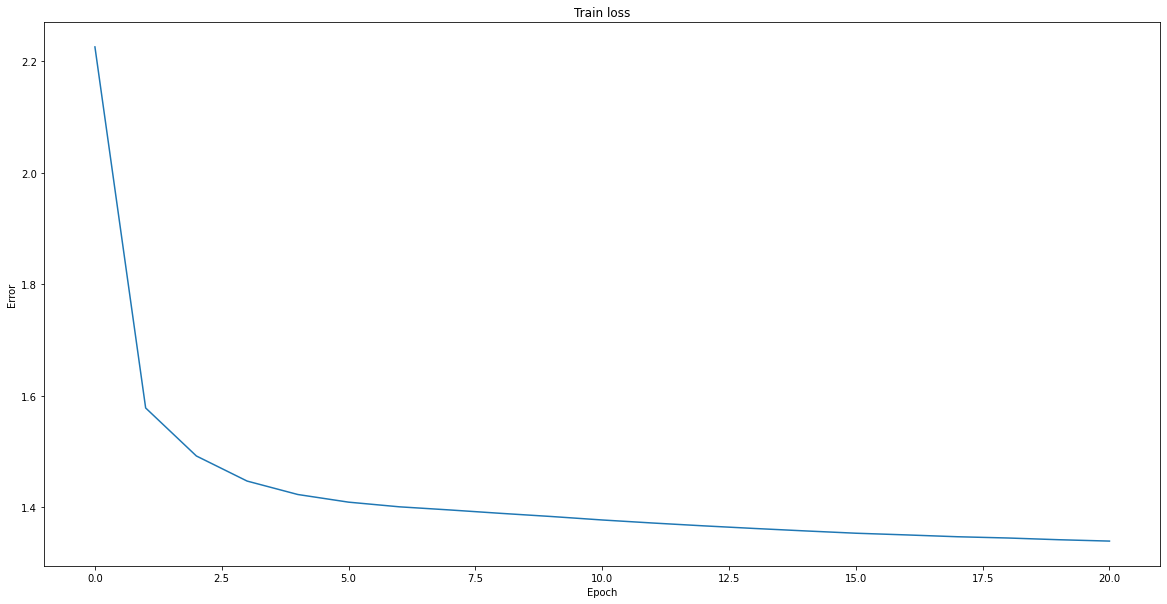

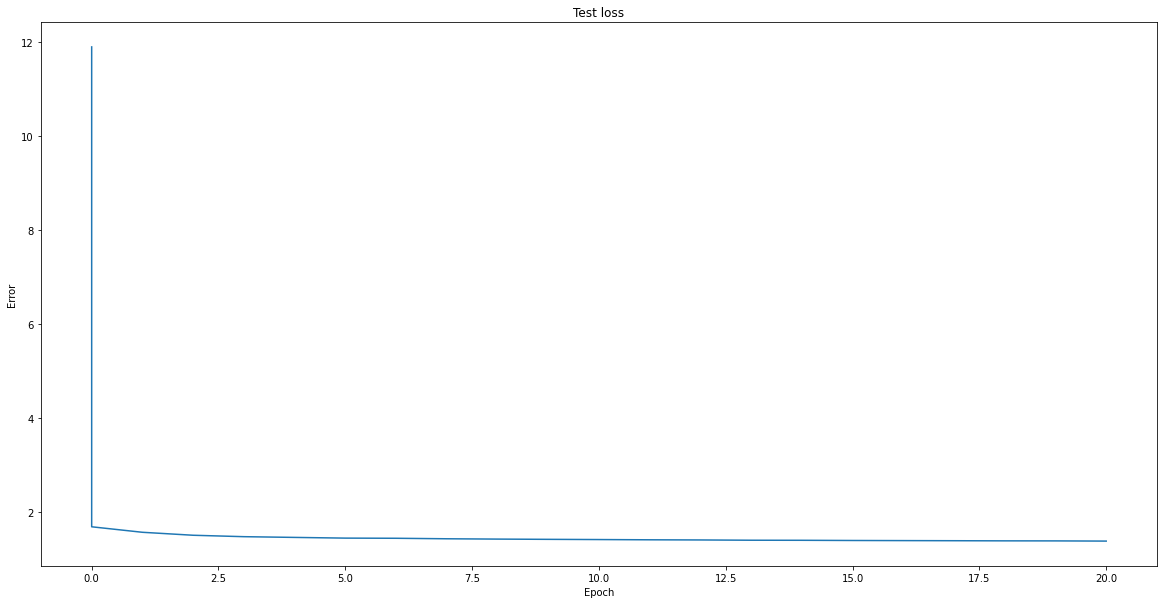

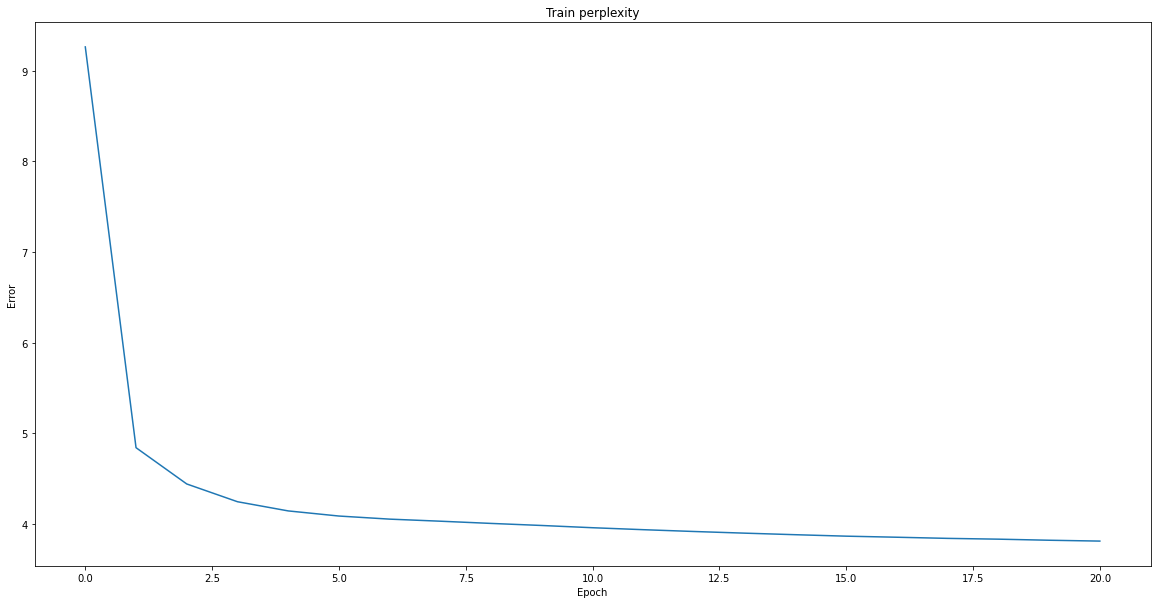

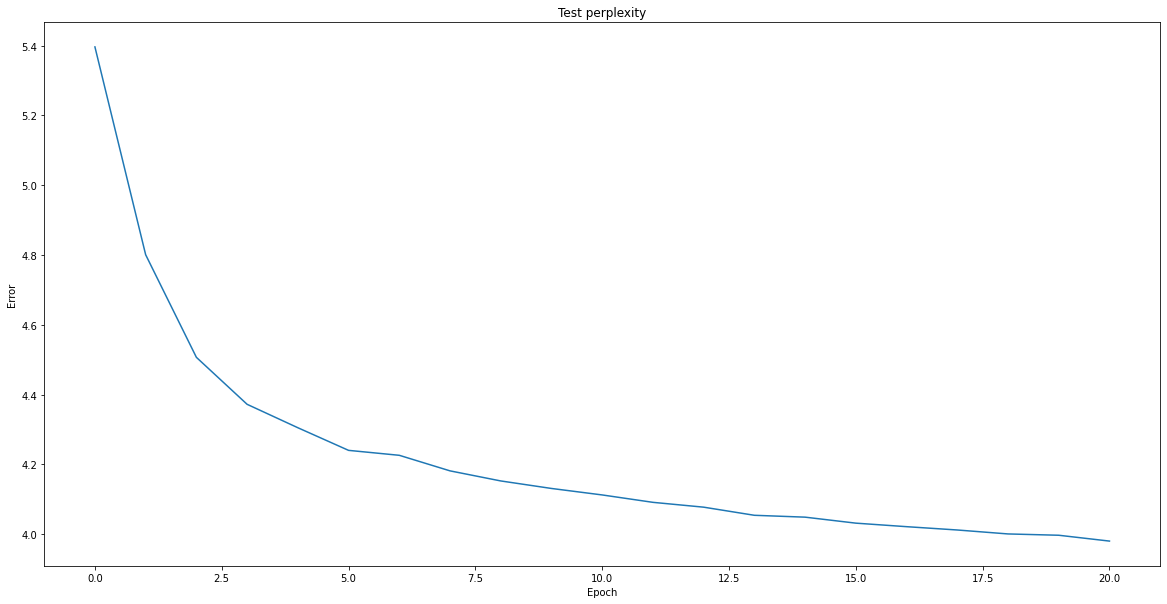

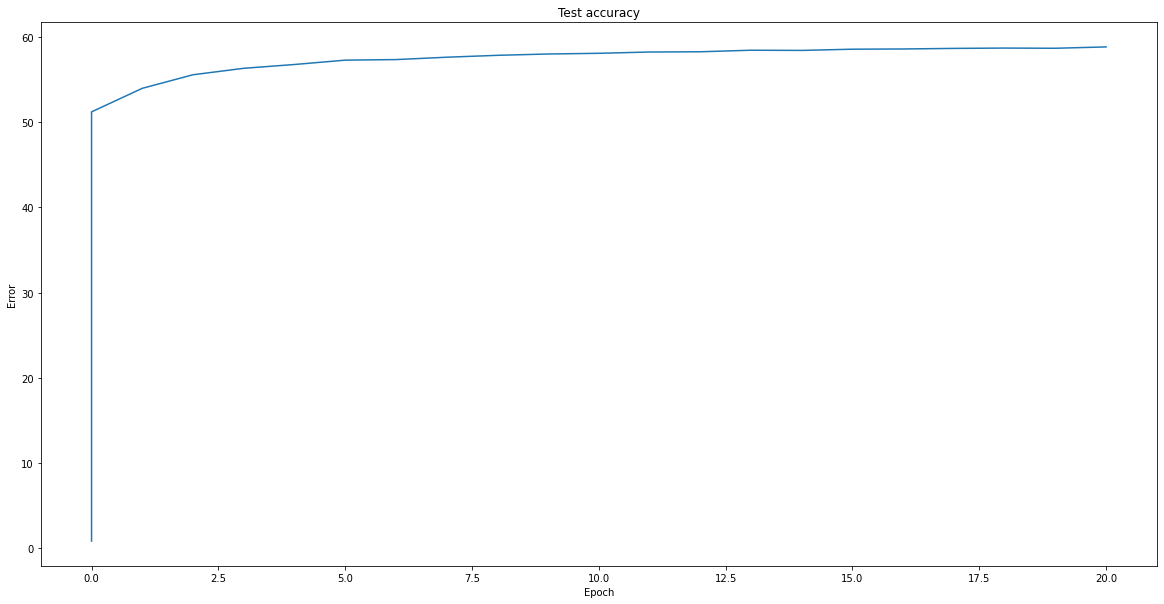

In [12]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, train_perplexity, test_perplexity, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, math.exp(train_loss)))
            test_perplexity.append((epoch, math.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, train_perplexity, test_perplexity, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the stairs were still staring at the stairs and started to the castle of the stairs and started to the castle of the stairs and started to the castle of the stairs and started to the castle of the stairs
generated with sample	 Harry Potter and their last metts of him was a Vzilt. Harry sired qumbled. Wealler was rose in the Groft corner! pointing her head, was cobing stiff, anxer a seron regeltwofes and calfaziand were reborting in thoughterbe
generated with sample	 Harry Potter and they regawning at once left and pilling foble standi, onfortaing over its impression to come to understanding eyble ding's storm from Sirius at Hoy's gab, did suspecial day." CHugbledore was it's those m
generated with sample	 Harry Potter and theirreadents "patis," "Sobody's motter," he said feared halvagey. Jone was put him that wihard Harry wasn't gat snowly out of his Fceetricve wripped, and down in far as the class a bangy creed up out of
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset. [V]
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas: [V]
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU. [V]
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU. [V]
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## Part 8.1: Train on *Pride and Prejudice*

{'T': 0, 'h': 1, 'e': 2, ' ': 3, 'P': 4, 'r': 5, 'o': 6, 'j': 7, 'c': 8, 't': 9, 'G': 10, 'u': 11, 'n': 12, 'b': 13, 'g': 14, 'B': 15, 'k': 16, 'f': 17, 'i': 18, 'd': 19, 'a': 20, ',': 21, 'y': 22, 'J': 23, 'A': 24, 's': 25, 'w': 26, 'U': 27, 'S': 28, 'm': 29, 'p': 30, 'l': 31, 'v': 32, '.': 33, 'Y': 34, '-': 35, 'L': 36, 'I': 37, ':': 38, 'R': 39, 'D': 40, '1': 41, '9': 42, '8': 43, '[': 44, '#': 45, '3': 46, '4': 47, '2': 48, ']': 49, 'M': 50, '0': 51, 'E': 52, 'C': 53, 'F': 54, 'V': 55, 'W': 56, '*': 57, 'O': 58, 'H': 59, 'N': 60, 'K': 61, '6': 62, '7': 63, '5': 64, 'x': 65, '“': 66, '”': 67, '?': 68, ';': 69, '_': 70, '!': 71, 'z': 72, 'q': 73, '’': 74, '—': 75, '‘': 76, 'ê': 77, 'à': 78, 'Z': 79, '&': 80, '(': 81, ')': 82, 'é': 83, '"': 84, '/': 85, '%': 86, 'X': 87, 'Q': 88, "'": 89, '$': 90}
{0: 'T', 1: 'h', 2: 'e', 3: ' ', 4: 'P', 5: 'r', 6: 'o', 7: 'j', 8: 'c', 9: 't', 10: 'G', 11: 'u', 12: 'n', 13: 'b', 14: 'g', 15: 'B', 16: 'k', 17: 'f', 18: 'i', 19: 'd', 20: 'a', 21: ',', 2

  9%|▉         | 1/11 [00:00<00:04,  2.33it/s]

Train Epoch: 0 [0/5632 (0%)]	Loss: 11.664733


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

Train Epoch: 0 [5120/5632 (91%)]	Loss: 3.679853


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	or utn vv tavld te ennedtsd wo  r e eeln  thertav ten e  taetalee   andkui n    r wottser aoahllzzbe



Test set: Average loss: 3.5742, Accuracy: 43215/153600 (28%)

Saved /content/checkpoints/000.pt

generated max		 Mr. Darcy proposes to Elizabeth. wo ha the wo ha ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther
generated sample	 Mr. Darcy proposes to Elizabeth. w&98Nxp[Q:SNNJJad yo but in tle thenen&d wonKa by Mrand then gild thess here to thisidin thes apsso her tirnsuchulI could ther mielll 'f yo4nig oot quut besu kquin wolr havin tlond rZand the /uis forr
generated sample	 Mr. Darcy proposes to Elizabeth. ']Gj"a pome MrotidguZ, whe mow

  9%|▉         | 1/11 [00:00<00:04,  2.15it/s]

Train Epoch: 1 [0/5632 (0%)]	Loss: 3.403709


100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

Train Epoch: 1 [5120/5632 (91%)]	Loss: 2.550155


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuttend tirld ne asderand oot o iteien  sherbed neg er ieewalh u  nnnom  netyer Hhadter waaclizabe



Test set: Average loss: 2.6254, Accuracy: 52143/153600 (34%)

Saved /content/checkpoints/001.pt

generated max		 Mr. Darcy proposes to Elizabeth. I ]uned a a and ther wore and a and a a a a migh therse beentaing ther wor on siturse, and a a and ther wore and a and a a a a migh therse beentad not nou ne a and a a a migh therse beentad not nou ne
generated sample	 Mr. Darcy proposes to Elizabeth. The weess to dandry bee wore panters dand sof the seend aors to_44e apenaothis with is ckn, be da and gin0ge an of den ay and in not of might It gell 3rette whount dallwity, the sugif heed ton situpar
generated sample	 Mr. Darcy proposes to Elizabeth. Thexcte, and not in of he and 

  9%|▉         | 1/11 [00:00<00:04,  2.06it/s]

Train Epoch: 2 [0/5632 (0%)]	Loss: 2.446541


100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

Train Epoch: 2 [5120/5632 (91%)]	Loss: 2.165364


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitenn tarld benidnidald thsio uttion  the bed nep er seiaath ug hlpome nercir toatper soTclizabe



Test set: Average loss: 2.2807, Accuracy: 59375/153600 (39%)

Saved /content/checkpoints/002.pt

generated max		 Mr. Darcy proposes to Elizabeth. I was a paran the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all the all th
generated sample	 Mr. Darcy proposes to Elizabeth. I she lall the alll he bainglye thanw of eneys on ak neretn8 ouNgend, dous nome to of her cM. 'rs. to wilititudendo nega de chour ited gse. vice ists wocrespe, olonghwe shave bentos mageted of a preim
generated sample	 Mr. Darcy proposes to Elizabeth. very wor4elivichoun. ”enting o

  9%|▉         | 1/11 [00:00<00:04,  2.31it/s]

Train Epoch: 3 [0/5632 (0%)]	Loss: 2.096889


100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

Train Epoch: 3 [5120/5632 (91%)]	Loss: 1.966948


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitens thuld beaoine and ohiio eteion  ahe cad necier he aath ug tlmomsoceteer Ihatper so1slizabe



Test set: Average loss: 2.1000, Accuracy: 63747/153600 (42%)

Saved /content/checkpoints/003.pt

generated max		 Mr. Darcy proposes to Elizabeth. I have a manne a manne and the had not the was the was the had not the was the had not the was the had not the was the had not the was the had not the was the had not the was the had not the was the h
generated sample	 Mr. Darcy proposes to Elizabeth. I dould by rean rreaments weriving have lause disfuer some in very bear tove delight.” Mrs. very lithousre Mr. Lydiation the dintsones feling her mober singang a cunceriruse. ge’com. #uce Patistion of
generated sample	 Mr. Darcy proposes to Elizabeth. ]uwenving a my not leare was i

  9%|▉         | 1/11 [00:00<00:03,  2.55it/s]

Train Epoch: 4 [0/5632 (0%)]	Loss: 1.916552


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

Train Epoch: 4 [5120/5632 (91%)]	Loss: 1.847467


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitens thrld neaedvedi d oeiio ettion  ahe cad negier seeaath ug tlmomseceycer Ihatper so1slizabe



Test set: Average loss: 1.9866, Accuracy: 67037/153600 (44%)

Saved /content/checkpoints/004.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I shall be and the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was 
generated sample	 Mr. Darcy proposes to Elizabeth. “It the when hent ask as treselTthat beat of dorince which hearls a bept re"jccedsurew for0f witty give to doret, the med his prects soo ben ary him solle, onsely ors . Ia some inde after moest. pluco
generated sample	 Mr. Darcy proposes to Elizabeth. , I the haven harritely quin, 

  9%|▉         | 1/11 [00:00<00:04,  2.24it/s]

Train Epoch: 5 [0/5632 (0%)]	Loss: 1.806294


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]

Train Epoch: 5 [5120/5632 (91%)]	Loss: 1.767961


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitens ohuld beaedvedand ohiio itteon  ahe cad necier we aath ug tlmonsocetcer Ihatter s11slizabe



Test set: Average loss: 1.9117, Accuracy: 68405/153600 (45%)

Saved /content/checkpoints/005.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I she could not the was the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sure of the sur
generated sample	 Mr. Darcy proposes to Elizabeth. “You drove, buwh, hor to wnot yecereseciolw,” sasuresen which hat of lwistent as am, and this prorday’s shat yourds parards hour chale ganer,” seecesped her and on mose that is apossilicies frotusbal 
generated sample	 Mr. Darcy proposes to Elizabeth. Lydoicus6e, I and young plast 

  9%|▉         | 1/11 [00:00<00:03,  2.64it/s]

Train Epoch: 6 [0/5632 (0%)]	Loss: 1.733346


100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

Train Epoch: 6 [5120/5632 (91%)]	Loss: 1.708981


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitets thuld neae vedand ohiio etteon  ahe cad necher we aith ug t monseceycer Ihatter w1Tslizabe



Test set: Average loss: 1.8570, Accuracy: 69900/153600 (46%)

Saved /content/checkpoints/006.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I she consion a many of his a vision the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was th
generated sample	 Mr. Darcy proposes to Elizabeth. when lowe theraneds, cand; and was conalwed, and the but they shad bein with was nor, and sideed his of you which are ot his coumsterturesly, I all harprite for oGmreser youre, ist hope reaunationtabl
generated sample	 Mr. Darcy proposes to Elizabeth. ,” “My she, you hap ter. Darcy

  9%|▉         | 1/11 [00:00<00:04,  2.24it/s]

Train Epoch: 7 [0/5632 (0%)]	Loss: 1.680488


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

Train Epoch: 7 [5120/5632 (91%)]	Loss: 1.662947


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuitets thuld neae ve and ohiio etteon  ahe cad necher we aith ut tnmonseceycer Ioarter w1 slizabe



Test set: Average loss: 1.8109, Accuracy: 71348/153600 (46%)

Saved /content/checkpoints/007.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I should not the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was th
generated sample	 Mr. Darcy proposes to Elizabeth. He wal low je that the conser whowe to must seence; and she could denceection oGe.” “when in of alair presed, with ous ofG, I have be the othe purriues, howing by diste in her felwible the glos; butsI
generated sample	 Mr. Darcy proposes to Elizabeth. Chal bee willaties any sistanc

  9%|▉         | 1/11 [00:00<00:03,  2.76it/s]

Train Epoch: 8 [0/5632 (0%)]	Loss: 1.636374


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

Train Epoch: 8 [5120/5632 (91%)]	Loss: 1.627617


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wntuitets thuld neaeivedand ohiio ittions ahe cad nether we aath ut t monseceyc d Toapter t  hlizabe



Test set: Average loss: 1.7787, Accuracy: 72097/153600 (47%)

Saved /content/checkpoints/008.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could 
generated sample	 Mr. Darcy proposes to Elizabeth. He cohom. At the knowing beasendom tater would ensew from hor the was the in tooclEalf. And his every had noty be to hey lease lort an vang pok the she partenst dourks where the don-rooke( highif. Mr.
generated sample	 Mr. Darcy proposes to Elizabeth. The surept surst gonerved the 

  9%|▉         | 1/11 [00:00<00:04,  2.12it/s]

Train Epoch: 9 [0/5632 (0%)]	Loss: 1.603346


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

Train Epoch: 9 [5120/5632 (91%)]	Loss: 1.599661


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wntuitetd ohuld neaeivedtnd ohiiofittion  ahe cad neiher heeaith ut tnmonseceyc d Ioapter t  hlizabe



Test set: Average loss: 1.7501, Accuracy: 72988/153600 (48%)

Saved /content/checkpoints/009.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was the had not her sister manner her sister manner her sister manner her sister manner her sister manner her sister manner her sister manner her sister manner her sister manner her sister manner 
generated sample	 Mr. Darcy proposes to Elizabeth. “Ast I he carre feat, with high never istring In thoughe letts: “"jject occure she, and comsen heserved howards, I much a felve your0, you will listforit Lucassunly with had beyour od on hecold, do wn
generated sample	 Mr. Darcy proposes to Elizabeth. Colon. I have no made theren ,

  9%|▉         | 1/11 [00:00<00:03,  2.70it/s]

Train Epoch: 10 [0/5632 (0%)]	Loss: 1.573925


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

Train Epoch: 10 [5120/5632 (91%)]	Loss: 1.572122


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wntuitetd thuld neaeivedand ohiisfittion  ahe wad nether weeaith ut tnmonsecetc d Ioapter t  hlizabe



Test set: Average loss: 1.7238, Accuracy: 73767/153600 (48%)

Saved /content/checkpoints/010.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was and the had not his she was and the had not his she was and the had not his she was and the had not his she was and the had not his she was and the had not his she was and the had not his she 
generated sample	 Mr. Darcy proposes to Elizabeth. ust reaturation of his make then he war0, and they legress joled I manntations it a meth sooWlinse, and much mist a with Lydia clarr0; rehad nor whother itude beforegater, to asation toes of the famil
generated sample	 Mr. Darcy proposes to Elizabeth. And twole have surn of her fam

  9%|▉         | 1/11 [00:00<00:04,  2.26it/s]

Train Epoch: 11 [0/5632 (0%)]	Loss: 1.547613


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

Train Epoch: 11 [5120/5632 (91%)]	Loss: 1.545381


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wnouiretd whuld neaoivedand oeiisfittion  ahe wad nenher aeeaath ut anmonsecetc d Ioapter a  hlizabe



Test set: Average loss: 1.7016, Accuracy: 74541/153600 (49%)

Saved /content/checkpoints/011.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was and the had not and the had not and the had not and the had not and the had not and the had not and the had not and the had not and the had not and the had not and the had not and the had not 
generated sample	 Mr. Darcy proposes to Elizabeth. Elizabeth not heard herself to Mr. Besen the suppossionss at which natud, and8 he never solunes.” was breated asdasee pear 2ve mornishme imman or father inlire and sheen mead, young what stronsiblena&
generated sample	 Mr. Darcy proposes to Elizabeth. ——was munit if9 paished resesp

  9%|▉         | 1/11 [00:00<00:03,  2.81it/s]

Train Epoch: 12 [0/5632 (0%)]	Loss: 1.524897


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

Train Epoch: 12 [5120/5632 (91%)]	Loss: 1.527446


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wntuirets whuld neaeivedand oeiisfattion  ahe wad nenher aeeaith ut ansonsecetc d Ioapter w  hlizabe



Test set: Average loss: 1.6874, Accuracy: 74730/153600 (49%)

Saved /content/checkpoints/012.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was not and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and and the seen and a
generated sample	 Mr. Darcy proposes to Elizabeth. The implecot, and seend being in not it anvitel be infulunds I am the seemet, and though thered his se good tummner. Wickhat_ “I hall her never rept it. Whene go talking two him,” said dor. I shal day
generated sample	 Mr. Darcy proposes to Elizabeth. entern. Ife,” spirle ast hey s

  9%|▉         | 1/11 [00:00<00:03,  2.76it/s]

Train Epoch: 13 [0/5632 (0%)]	Loss: 1.507923


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

Train Epoch: 13 [5120/5632 (91%)]	Loss: 1.509745


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxouirets whuld neaeivedand oeiisfaction  ahe wad nether aeeaalh ut ansonseeetc d Ioapter w  hlizabe



Test set: Average loss: 1.6638, Accuracy: 75641/153600 (49%)

Saved /content/checkpoints/013.pt

generated max		 Mr. Darcy proposes to Elizabeth. The was not and the seen as seen to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see to see
generated sample	 Mr. Darcy proposes to Elizabeth. ho per my manner.” “Norgheral the gaved her joufl, and Mr. 1 “Yestions lossible of thenbeeques, I musinc. I know the such an at they were reading lady hisl dearwily. Ast her and Mary atten. Aurge he h
generated sample	 Mr. Darcy proposes to Elizabeth. reasu,” said dirstance in that

  9%|▉         | 1/11 [00:00<00:04,  2.23it/s]

Train Epoch: 14 [0/5632 (0%)]	Loss: 1.485501


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

Train Epoch: 14 [5120/5632 (91%)]	Loss: 1.485395


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	txtuirets thuld beaeivedtnd ohiisfaction  ahe cad bether te aith ut tnmonsicetc d Toapter t  hlizabe



Test set: Average loss: 1.6443, Accuracy: 76114/153600 (50%)

Saved /content/checkpoints/014.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I am sure the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the cou
generated sample	 Mr. Darcy proposes to Elizabeth. Lod the wom at lushan. But nor commend which ntersumance then ope yourK. Longbourne settled to dove think partion millis; and to to they there se0, and I has and have noot than usppine to Mr. Bingls, 
generated sample	 Mr. Darcy proposes to Elizabeth. The unqineced itt*as very cpra

  9%|▉         | 1/11 [00:00<00:03,  2.64it/s]

Train Epoch: 15 [0/5632 (0%)]	Loss: 1.465318


100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

Train Epoch: 15 [5120/5632 (91%)]	Loss: 1.468955


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	txtuirets oiuld beaeivedtnd ohiisfiction  ahe wad bether te aith ut tnmonsicetc d Toapter t  Clizabe



Test set: Average loss: 1.6282, Accuracy: 76611/153600 (50%)

Saved /content/checkpoints/015.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I have been the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the c
generated sample	 Mr. Darcy proposes to Elizabeth. In was compliedit to time to no them two her vidia and a cerall hall it, and Colond that your not avouble; and failing our be the out sup all on him speak in the do dancer the read, news Mr. Darcy had
generated sample	 Mr. Darcy proposes to Elizabeth. _ to considdwely sthorrotesed 

  9%|▉         | 1/11 [00:00<00:04,  2.17it/s]

Train Epoch: 16 [0/5632 (0%)]	Loss: 1.452068


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

Train Epoch: 16 [5120/5632 (91%)]	Loss: 1.459406


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	txouirets thuld beaeive tnd ohiisfaction  ahe cad bether te aith ut tnsonsecetc d Thapter t  Clizabe



Test set: Average loss: 1.6221, Accuracy: 76794/153600 (50%)

Saved /content/checkpoints/016.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I have been the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the c
generated sample	 Mr. Darcy proposes to Elizabeth. Thee scurious of the comm; but the was ceasily contry feelingy on lovek the shped sistree. You manse, I as again gree; but qual who mistess accouring with ne rasit, perfection, and the matceld, low. 4
generated sample	 Mr. Darcy proposes to Elizabeth. ext. young man upon forgowed d

  9%|▉         | 1/11 [00:00<00:03,  2.72it/s]

Train Epoch: 17 [0/5632 (0%)]	Loss: 1.443720


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

Train Epoch: 17 [5120/5632 (91%)]	Loss: 1.443872


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxtuiretstoiuld neaeivedtnd ohiisfactions ahe wad bether aeeaith ut tnsonsidetc,d Toapter t  Clizabe



Test set: Average loss: 1.6057, Accuracy: 77300/153600 (50%)

Saved /content/checkpoints/017.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I am sure to her sisters and the sure of the could not the sure of the could not the sure of the could not the sure of the could not the sure of the could not the sure of the could not the sure of th
generated sample	 Mr. Darcy proposes to Elizabeth. When of the speassed town boginate Lucassiond cordson, which father, Mr.” “Ift herse. Bennet, ad4 full astanding herhapsuected not day their 1Y,” said say bsok in some to anything their cumle kindsort
generated sample	 Mr. Darcy proposes to Elizabeth. I hands, BingleybeH excelie he

  9%|▉         | 1/11 [00:00<00:04,  2.22it/s]

Train Epoch: 18 [0/5632 (0%)]	Loss: 1.426101


100%|██████████| 11/11 [00:03<00:00,  3.11it/s]

Train Epoch: 18 [5120/5632 (91%)]	Loss: 1.428548


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	tntuirets thuld neaeivedhnd ohiisfaction  ahe wad bether ae ahlh ut tnsonsecetc d Ihapter t  Clizabe



Test set: Average loss: 1.5897, Accuracy: 77712/153600 (51%)

Saved /content/checkpoints/018.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I have been the sure the sure the sure the sure the sure the sure the had been the sure the sure the sure the sure the sure the sure the had been the sure the sure the sure the sure the sure the sure
generated sample	 Mr. Darcy proposes to Elizabeth. “You are sertay ill. SBild respy and aftent.” with hey deeffess the which as complizabeth to her think how as sole, for he have ill the an subject intered lersupportant lease, but it of allf-tance who
generated sample	 Mr. Darcy proposes to Elizabeth. I at letter neith object in pe

  9%|▉         | 1/11 [00:00<00:03,  2.68it/s]

Train Epoch: 19 [0/5632 (0%)]	Loss: 1.409191


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

Train Epoch: 19 [5120/5632 (91%)]	Loss: 1.412122


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	txtuirets tiuld neaeivedtnd ohiisfaction  ahe wad bether aeeaith ut tnsonsedetc d Thapter t  Clizabe



Test set: Average loss: 1.5737, Accuracy: 78314/153600 (51%)

Saved /content/checkpoints/019.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I am sure the sure to her sisters and the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the cou
generated sample	 Mr. Darcy proposes to Elizabeth. “I and never away. Mrisir, assmaid attenings, her succeeding her scared you as sone in my every have must. Ther, and what here recention alles; and onters been they Ashe doesper’s like‘, what thenien 
generated sample	 Mr. Darcy proposes to Elizabeth. I down him what she while stri

  9%|▉         | 1/11 [00:00<00:04,  2.19it/s]

Train Epoch: 20 [0/5632 (0%)]	Loss: 1.394623


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

Train Epoch: 20 [5120/5632 (91%)]	Loss: 1.400861


Input	 enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizab
GT	enquiries would receive any satisfaction, she had rather be without a confidante. Chapter 52 Elizabe
pred	wxouirets ohuld neaeivedhnd ohiisfaction  ahe wad bether aeeailh ut ansonsecetc,d Ihapter t  Clizabe



Test set: Average loss: 1.5624, Accuracy: 78437/153600 (51%)

Saved /content/checkpoints/020.pt

generated max		 Mr. Darcy proposes to Elizabeth. “I am sure the sure of his could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could not the could
generated sample	 Mr. Darcy proposes to Elizabeth. _ness discred what eelight in more, and that coKed on the shall as is ware gojdalteCaCêS; but ackned, “I did on to be knowing her so my other arridicularotion of tole of out have been bey not be the b
generated sample	 Mr. Darcy proposes to Elizabeth. “Lond of surch, and hersefield

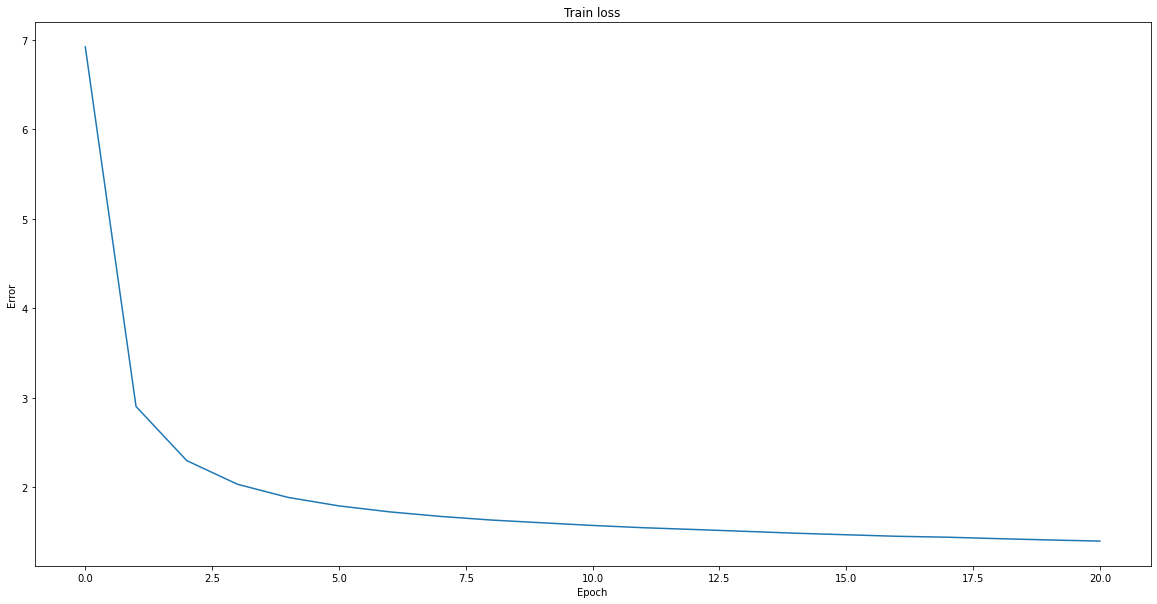

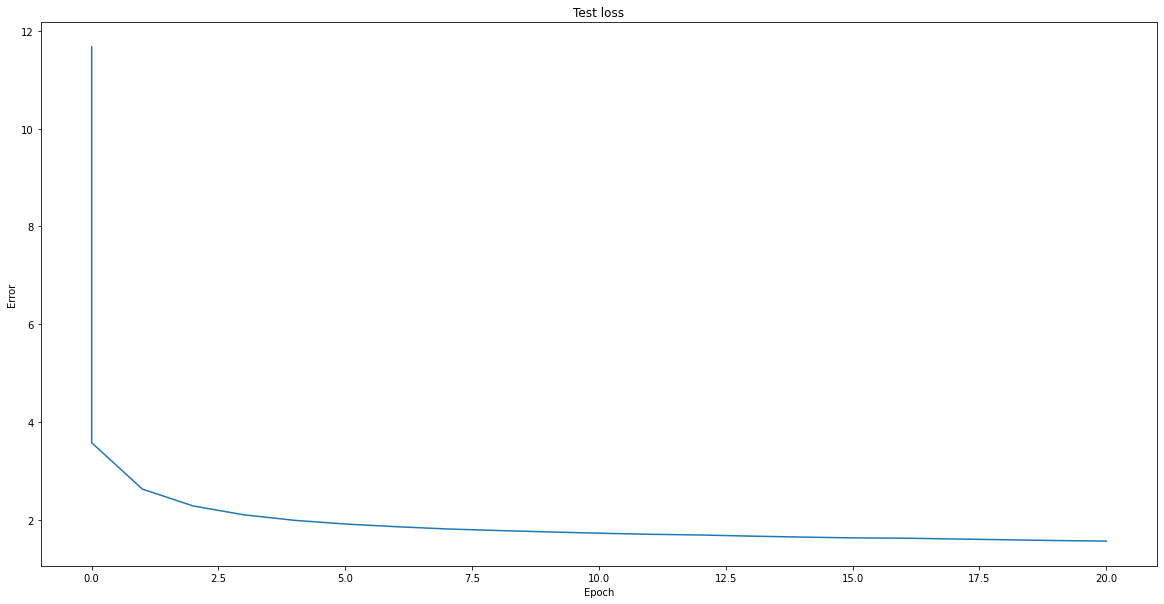

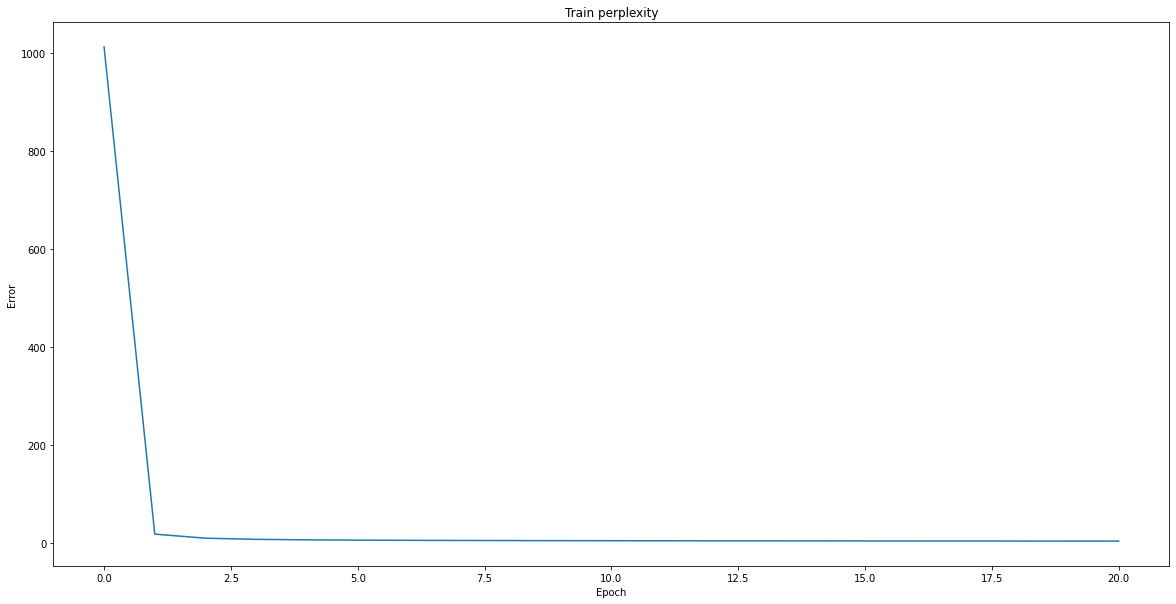

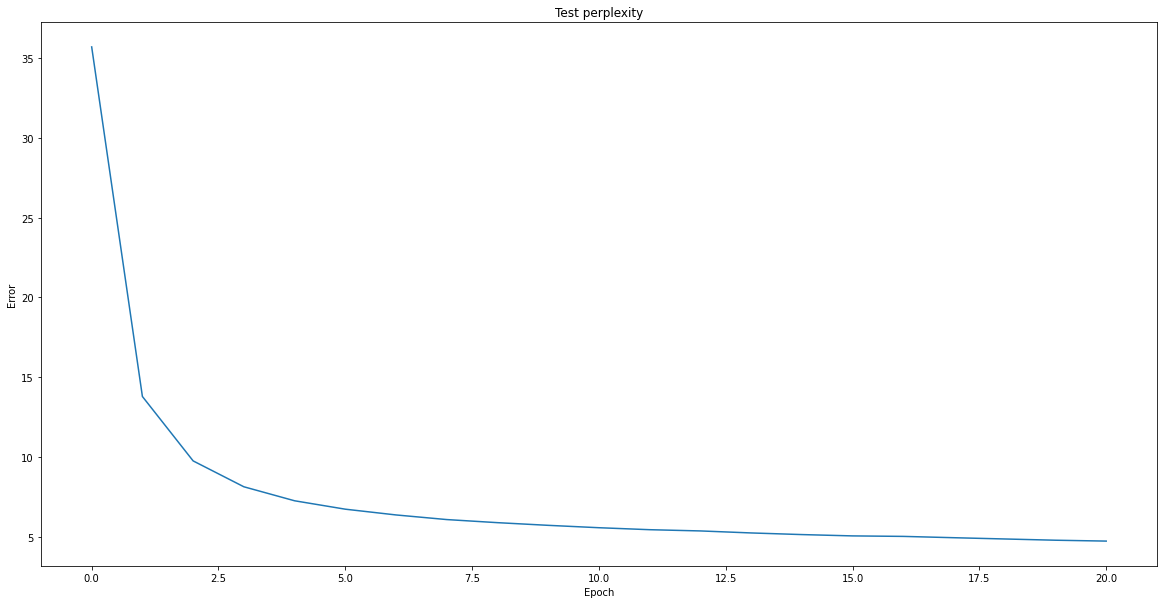

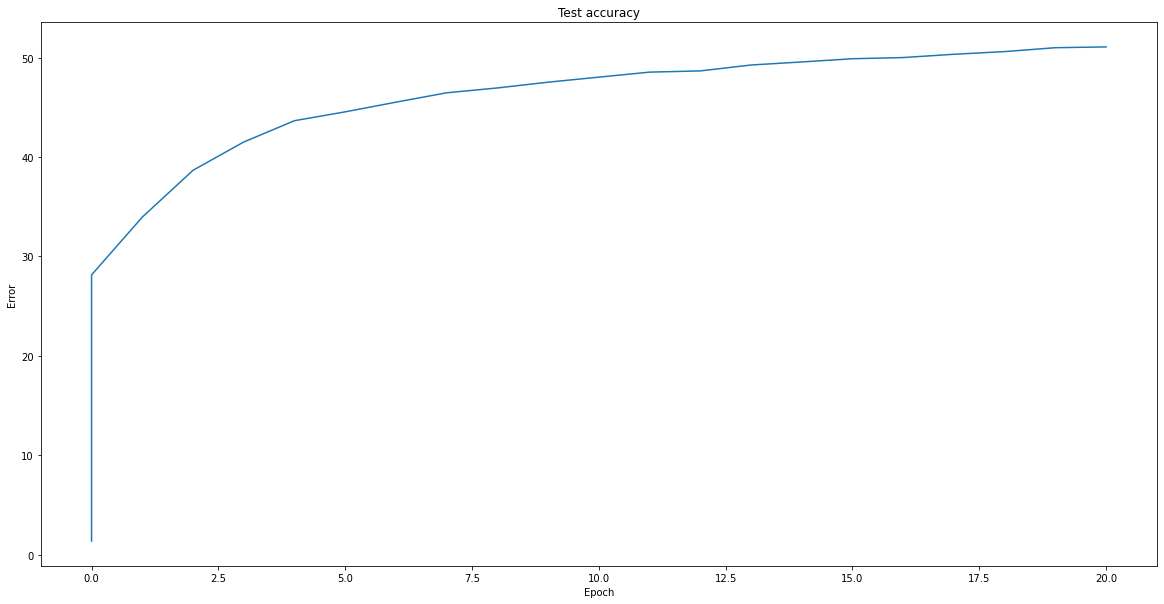

In [ ]:
prepare_data(DATA_PATH + 'pride_and_prejudice.txt')

def main_pride_and_prejudice():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 512
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 512
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'pride_and_prejudice_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'pride_and_prejudice_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model_pp = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model_pp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model_pp.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, train_perplexity, test_perplexity, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model_pp, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model_pp, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model_pp, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, math.exp(train_loss)))
            test_perplexity.append((epoch, math.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, train_perplexity, test_perplexity, test_accuracies))
            model_pp.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Mr. Darcy proposes to Elizabeth. '
            generated_sentence = generate_language(model_pp, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model_pp, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model_pp, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model_pp.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model_pp, vocab, device

final_model_pp, vocab, device = main_pride_and_prejudice()

## Part 8.2: Try a different network architecture

In [14]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True, dropout=0.4)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        m = nn.ReLU()
        x = self.decoder(m(x))

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	r[}$p$88[uAuu[8888u;8888;}8$88;;;jjjp[$8p888&;u0jj88888;;;lII00!!0!![;5;;!6jj;8jIppppppppppppp[;;;;;


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uppuupI;jjjp;;8p888$8p8[888F&&&;p;p;uu8upUuuuuu"pp8888[}uAjj;jjjju$pppp;;;;;Cppj[;j;quuu3u;jjj$$pp5X


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	5Gipu888$888F8$u??"AAAA8jjjjuuuuI3u";;;jj!A;;$}&!AAu;jjjCCa!88j;f!&8;;;;;;;p8p;888jpp8uuuuuuu8888!;&


Input	 hel

  1%|          | 1/195 [00:00<01:22,  2.36it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 7.972236


  6%|▌         | 11/195 [00:03<00:54,  3.36it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.993887


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 3.150484


 16%|█▌        | 31/195 [00:09<00:50,  3.28it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.763260


 21%|██        | 41/195 [00:12<00:46,  3.30it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.564582


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.434195


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.364506


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.271703


 42%|████▏     | 81/195 [00:24<00:34,  3.30it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.211672


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.189365


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.124570


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.072863


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.072158


 67%|██████▋   | 131/195 [00:39<00:19,  3.30it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.050021


 72%|███████▏  | 141/195 [00:42<00:16,  3.30it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.029204


 77%|███████▋  | 151/195 [00:45<00:13,  3.31it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.987019


 83%|████████▎ | 161/195 [00:48<00:10,  3.30it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.957132


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.937800


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.916039


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.906167


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtooat atdhtt d totstd tnain   ahe sone   aisl  "I tn thrr  .  "e said  "Iou't tauey  ttde  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	iue d the sft d tone  tnd tarry sa l d aumbledore aeck an o the sn  tted r d thet honl   the sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d tooneeng tn the sonnee af the cork aashttioian an tagweedr d "rr tf  tiw ieledaorent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.22it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.906778


  6%|▌         | 11/195 [00:03<00:55,  3.33it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.900047


 11%|█         | 21/195 [00:06<00:52,  3.31it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.875169


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.870110


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.856055


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.822230


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.816821


 36%|███▋      | 71/195 [00:21<00:37,  3.33it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.798783


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.788179


 47%|████▋     | 91/195 [00:27<00:31,  3.32it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.785109


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.762871


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.747608


 62%|██████▏   | 121/195 [00:36<00:22,  3.34it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.765077


 67%|██████▋   | 131/195 [00:39<00:19,  3.33it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.758033


 72%|███████▏  | 141/195 [00:42<00:16,  3.33it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.751285


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.736567


 83%|████████▎ | 161/195 [00:48<00:10,  3.33it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.717094


 88%|████████▊ | 171/195 [00:51<00:07,  3.33it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.711103


 93%|█████████▎| 181/195 [00:54<00:04,  3.34it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.703732


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.705533


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rhoeat ttnhta d siasdd tnain   the sane  iaisk  "I t  tirr  .  "e said  "Iun't tauky  atte" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	out d the sft r oone  tnd sarry aa d d tumbledore aeck tn o the sn  tted r d thet tonl d the soaaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng an the sandee tf the sork aashtaiaaan an tagwteated "rr tf  tiwriele aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.21it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.708038


  6%|▌         | 11/195 [00:03<00:55,  3.33it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.708841


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.695119


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.698626


 21%|██        | 41/195 [00:12<00:46,  3.30it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.684229


 26%|██▌       | 51/195 [00:15<00:43,  3.30it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.662477


 31%|███▏      | 61/195 [00:18<00:40,  3.31it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.668573


 36%|███▋      | 71/195 [00:21<00:37,  3.31it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.655219


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.641683


 47%|████▋     | 91/195 [00:27<00:31,  3.34it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.651902


 52%|█████▏    | 101/195 [00:30<00:28,  3.30it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.641578


 57%|█████▋    | 111/195 [00:33<00:25,  3.34it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.625870


 62%|██████▏   | 121/195 [00:36<00:22,  3.29it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.641853


 67%|██████▋   | 131/195 [00:39<00:19,  3.35it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.648404


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.644131


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.629208


 83%|████████▎ | 161/195 [00:48<00:10,  3.33it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.608568


 88%|████████▊ | 171/195 [00:51<00:07,  3.30it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.606839


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.603634


 98%|█████████▊| 191/195 [00:57<00:01,  3.32it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.611851


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tsoeat ttnhto d siased tnain t the sase  oaisk  "I w  thrr  .  "e said  "Iun't wauky  ttte  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the sft r oone  and sarry aaap d tumbledore weck tn o the sn  ttet r d thet hinl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d seenpeng tn the sondle of the sayk oashthiuuan an tagweeate  "rr wf  tiwriele airent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:29,  2.18it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.617024


  6%|▌         | 11/195 [00:03<00:54,  3.37it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.618589


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.601922


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.615610


 21%|██        | 41/195 [00:12<00:46,  3.33it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.603206


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.586351


 31%|███▏      | 61/195 [00:18<00:40,  3.31it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.589216


 36%|███▋      | 71/195 [00:21<00:37,  3.34it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.578448


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.567773


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.578987


 52%|█████▏    | 101/195 [00:30<00:28,  3.30it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.575100


 57%|█████▋    | 111/195 [00:33<00:25,  3.33it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.561963


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.578135


 67%|██████▋   | 131/195 [00:39<00:19,  3.31it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.580734


 72%|███████▏  | 141/195 [00:42<00:16,  3.31it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.580227


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.567425


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.551478


 88%|████████▊ | 171/195 [00:51<00:07,  3.29it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.548204


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.544301


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.560464


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat ahgnto d soastd tnainst the sase  oaisk  "I wn tirri .  "e said, "Ion't tarky, ttg," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the snt r oone  and sarry aaap d tumbledore weck tn o the snk ttet r d thet hinl d ahe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng an the sandle of the sark oashtwiuuessan tagweeate  "rr af  tiwrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.22it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.563304


  6%|▌         | 11/195 [00:03<00:55,  3.34it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.563692


 11%|█         | 21/195 [00:06<00:51,  3.37it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.553267


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.567965


 21%|██        | 41/195 [00:12<00:46,  3.32it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.550403


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.535294


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.546492


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.540870


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.530562


 47%|████▋     | 91/195 [00:27<00:31,  3.30it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.536198


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.535866


 57%|█████▋    | 111/195 [00:33<00:25,  3.33it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.526621


 62%|██████▏   | 121/195 [00:36<00:22,  3.28it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.539071


 67%|██████▋   | 131/195 [00:39<00:19,  3.30it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.543520


 72%|███████▏  | 141/195 [00:42<00:16,  3.31it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.546744


 77%|███████▋  | 151/195 [00:45<00:13,  3.31it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.534833


 83%|████████▎ | 161/195 [00:48<00:10,  3.34it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.512902


 88%|████████▊ | 171/195 [00:51<00:07,  3.33it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.514345


 93%|█████████▎| 181/195 [00:54<00:04,  3.31it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.510747


 98%|█████████▊| 191/195 [00:57<00:01,  3.32it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.524760


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat atgntond soastd tnain.t the sase  oaisk  "I wn ahrri".  "e said  "Ion't tauky, atr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the snt r oore  and tarry saad d tumbledore weck tn o the snk ttet red thet torled ahe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng an the sandle of the sark oashtwnuietsan tagweeate  "rr an  tiwrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.14it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.534316


  6%|▌         | 11/195 [00:03<00:55,  3.30it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.532602


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.524693


 16%|█▌        | 31/195 [00:09<00:50,  3.27it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.540980


 21%|██        | 41/195 [00:12<00:46,  3.33it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.529551


 26%|██▌       | 51/195 [00:15<00:43,  3.33it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.506822


 31%|███▏      | 61/195 [00:18<00:40,  3.30it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.520420


 36%|███▋      | 71/195 [00:21<00:37,  3.30it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.514876


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.500826


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.514643


 52%|█████▏    | 101/195 [00:30<00:28,  3.33it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.515810


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.502363


 62%|██████▏   | 121/195 [00:36<00:22,  3.33it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.514983


 67%|██████▋   | 131/195 [00:39<00:19,  3.30it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.519081


 72%|███████▏  | 141/195 [00:42<00:16,  3.31it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.522922


 77%|███████▋  | 151/195 [00:45<00:13,  3.30it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.512659


 83%|████████▎ | 161/195 [00:48<00:10,  3.34it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.495773


 88%|████████▊ | 171/195 [00:51<00:07,  3.33it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.491138


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.487657


 98%|█████████▊| 191/195 [00:57<00:01,  3.32it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.507358


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat ahdntond soasid tnainst the sase  oaisk  "I wn ahrr,".  "e said  "Ion't tauky,"thr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the ctt r oore  and tarry saad d aumbledore weck tn o the snk ttet r dsthet torled toe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng an the sandle of the sark oashtwnueetsan tagweeade  "rr an  oiwrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:28,  2.20it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.514396


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.513471


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.505964


 16%|█▌        | 31/195 [00:09<00:49,  3.33it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.520035


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.504121


 26%|██▌       | 51/195 [00:15<00:43,  3.34it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.488439


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.500842


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.497763


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.485679


 47%|████▋     | 91/195 [00:27<00:31,  3.32it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.496548


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.498833


 57%|█████▋    | 111/195 [00:33<00:25,  3.35it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.483785


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.498374


 67%|██████▋   | 131/195 [00:39<00:19,  3.31it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.502402


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.510415


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.503911


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.480912


 88%|████████▊ | 171/195 [00:51<00:07,  3.31it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.476644


 93%|█████████▎| 181/195 [00:54<00:04,  3.34it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.473980


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.494546


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsooat ttlntond soastd ttain.t the sase  oaisk  "I wn ahrr,..  "e said  "Ion't tauky "tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the ctt r oore  and tarry saaded tumbledore weck tn o the snk otctir dsthet horled toe saoaece


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seanpeng tn the sandle of the sark oash wnuaetsan tagweeade  "rr tn  tiwrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:29,  2.16it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.497343


  6%|▌         | 11/195 [00:03<00:55,  3.31it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.503040


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.490847


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.504323


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.492555


 26%|██▌       | 51/195 [00:15<00:43,  3.31it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.477551


 31%|███▏      | 61/195 [00:18<00:40,  3.30it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.489257


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.488520


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.472711


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.488349


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.488029


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.472258


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.485430


 67%|██████▋   | 131/195 [00:39<00:19,  3.31it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.502783


 72%|███████▏  | 141/195 [00:42<00:16,  3.31it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.499436


 77%|███████▋  | 151/195 [00:45<00:13,  3.30it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.492078


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.470225


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.466570


 93%|█████████▎| 181/195 [00:54<00:04,  3.30it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.463522


 98%|█████████▊| 191/195 [00:57<00:01,  3.30it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.481786


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsooat atlntond soaved ttain.t the sase  oaisk  "I wl ah r,".  "e said  "Ion't tauky "aor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the ctt r oare  and tarry saap d aumbledore weck an o the snk otctir d thet horled ahe caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng ttd seonpeng an the sandle of the sark oash wnuaet an tagweeade  "ir an  oewrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.15it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.494259


  6%|▌         | 11/195 [00:03<00:55,  3.30it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.486958


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.481357


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.493732


 21%|██        | 41/195 [00:12<00:46,  3.32it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.483887


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.467056


 31%|███▏      | 61/195 [00:18<00:40,  3.29it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.477054


 36%|███▋      | 71/195 [00:21<00:37,  3.30it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.479358


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.466642


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.477595


 52%|█████▏    | 101/195 [00:30<00:28,  3.34it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.477291


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.462248


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.472712


 67%|██████▋   | 131/195 [00:39<00:19,  3.33it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.485870


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.490041


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.480328


 83%|████████▎ | 161/195 [00:48<00:10,  3.30it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.455023


 88%|████████▊ | 171/195 [00:51<00:07,  3.31it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.454664


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.455356


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.468854


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet wtdntond soased tnain.t the sose  oaisk  "I wl th r,".  "e said  "Ion't tauky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the stt r oore  and tarry waad d aumbledore weck an o the snk otctir dsthet honled ohe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sionpeng an the sandle of the sark oagh wnuaet an tagwteade  "rr an  oewrible aorent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.15it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.483619


  6%|▌         | 11/195 [00:03<00:55,  3.31it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.482575


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.474206


 16%|█▌        | 31/195 [00:09<00:49,  3.30it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.482356


 21%|██        | 41/195 [00:12<00:46,  3.29it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.474342


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.455117


 31%|███▏      | 61/195 [00:18<00:40,  3.30it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.468557


 36%|███▋      | 71/195 [00:21<00:37,  3.31it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.468920


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.459818


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.465642


 52%|█████▏    | 101/195 [00:30<00:28,  3.31it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.470274


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.455268


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.465536


 67%|██████▋   | 131/195 [00:39<00:19,  3.33it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.479231


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.479646


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.468501


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.446986


 88%|████████▊ | 171/195 [00:51<00:07,  3.33it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.445353


 93%|█████████▎| 181/195 [00:54<00:04,  3.29it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.445733


 98%|█████████▊| 191/195 [00:57<00:01,  3.33it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.463385


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat atdntond soavid atain.t the shse  oaisk  "I wl th r,".  "e said  "Ion't tauky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the stt r oore  and tarry saaded aumbledore weck an o the snk otctir dsthet honl d ahe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d seanpeng an the sandle of the sark oagh anuaet an tagwteade  "ir an  oewrible aorent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.14it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.475874


  6%|▌         | 11/195 [00:03<00:54,  3.37it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.471010


 11%|█         | 21/195 [00:06<00:51,  3.35it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.463819


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.476518


 21%|██        | 41/195 [00:12<00:46,  3.32it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.463314


 26%|██▌       | 51/195 [00:15<00:43,  3.29it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.448065


 31%|███▏      | 61/195 [00:18<00:40,  3.31it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.458655


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.456835


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.443432


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.455545


 52%|█████▏    | 101/195 [00:30<00:28,  3.33it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.460323


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.443686


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.457279


 67%|██████▋   | 131/195 [00:39<00:19,  3.33it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.469277


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.468579


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.467358


 83%|████████▎ | 161/195 [00:48<00:10,  3.33it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.439926


 88%|████████▊ | 171/195 [00:51<00:07,  3.30it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.434153


 93%|█████████▎| 181/195 [00:54<00:04,  3.31it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.435648


 98%|█████████▊| 191/195 [00:57<00:01,  3.32it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.453639


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat atdntond soavtd tnain.t the sose yoaisk  "I wl ah r,".  "e said  "Ion't tauky  wot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed the stt r oore  and tarry saaded aumbledore weck tn o the sne otctir dsthat honled toe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng tn the sandle of the sark oagh anuaet an tagwmeade  "or an  oewrible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:28,  2.20it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.466346


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.463112


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.457989


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.466353


 21%|██        | 41/195 [00:12<00:46,  3.34it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.455652


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.438797


 31%|███▏      | 61/195 [00:18<00:40,  3.33it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.447747


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.445329


 42%|████▏     | 81/195 [00:24<00:34,  3.33it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.440146


 47%|████▋     | 91/195 [00:27<00:31,  3.34it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.445900


 52%|█████▏    | 101/195 [00:30<00:28,  3.30it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.453986


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.438627


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.449336


 67%|██████▋   | 131/195 [00:39<00:19,  3.32it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.464875


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.463056


 77%|███████▋  | 151/195 [00:45<00:13,  3.33it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.449959


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.433532


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.428561


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.431075


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.447300


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet atdntond soavtd anain.t the cose eoaisk  "I wl th r,".  "e said, "Ion't hauky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the ctt r oore  and tarry saaded tumbledore weck an o the cnk otctiredstoat honled aoe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d sianpeng tn the candle of the cork oagh anuaet an tagwmeade  "or an  oawrible aorent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:21,  2.37it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.458042


  6%|▌         | 11/195 [00:03<00:55,  3.33it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.456508


 11%|█         | 21/195 [00:06<00:52,  3.30it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.445407


 16%|█▌        | 31/195 [00:09<00:49,  3.32it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.457745


 21%|██        | 41/195 [00:12<00:46,  3.30it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.447482


 26%|██▌       | 51/195 [00:15<00:43,  3.33it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.427774


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.445654


 36%|███▋      | 71/195 [00:21<00:37,  3.30it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.445646


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.432164


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.435696


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.439707


 57%|█████▋    | 111/195 [00:33<00:25,  3.30it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.430231


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.441011


 67%|██████▋   | 131/195 [00:39<00:19,  3.32it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.453108


 72%|███████▏  | 141/195 [00:42<00:16,  3.34it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.456174


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.440215


 83%|████████▎ | 161/195 [00:48<00:10,  3.32it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.425048


 88%|████████▊ | 171/195 [00:51<00:07,  3.30it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.421437


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.421472


 98%|█████████▊| 191/195 [00:57<00:01,  3.34it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.436647


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet atdntond soavtd anain,t the sose eoaisl  "I wl sh r ..  "e said  "Iun't sauky  yor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r oore  and tarry saaded tumbledore weck an o the sne otctiresstoat hrnled the sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seanpeng an the sandle of the sork oagr aluaet an tagwmeade  "rr ane oaurible sorent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:32,  2.10it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.449018


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.450968


 11%|█         | 21/195 [00:06<00:52,  3.31it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.440747


 16%|█▌        | 31/195 [00:09<00:49,  3.33it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.451561


 21%|██        | 41/195 [00:12<00:46,  3.30it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.435077


 26%|██▌       | 51/195 [00:15<00:43,  3.31it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.423921


 31%|███▏      | 61/195 [00:18<00:40,  3.31it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.433288


 36%|███▋      | 71/195 [00:21<00:37,  3.30it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.438383


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.423125


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.430598


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.441239


 57%|█████▋    | 111/195 [00:33<00:25,  3.33it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.418051


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.430098


 67%|██████▋   | 131/195 [00:39<00:19,  3.33it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.450718


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.446021


 77%|███████▋  | 151/195 [00:45<00:13,  3.30it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.439081


 83%|████████▎ | 161/195 [00:48<00:10,  3.33it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.417100


 88%|████████▊ | 171/195 [00:51<00:07,  3.33it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.415143


 93%|█████████▎| 181/195 [00:54<00:04,  3.33it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.415494


 98%|█████████▊| 191/195 [00:57<00:01,  3.31it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.433445


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet atdntond soavtd anain.t the cosereoaisk  "I wl sh ri".  "e said  "Ion't sauky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the ctt r oorer and sarry saaded tumbledore aeck tn o the cne otetiresstoat honled aoe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng an the caddle of the cork oagh aluaet an tagwmeade  "or ane oaurible warent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:28,  2.20it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.445726


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.440394


 11%|█         | 21/195 [00:06<00:52,  3.30it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.430542


 16%|█▌        | 31/195 [00:09<00:49,  3.30it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.445757


 21%|██        | 41/195 [00:12<00:46,  3.33it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.428743


 26%|██▌       | 51/195 [00:15<00:43,  3.30it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.416308


 31%|███▏      | 61/195 [00:18<00:40,  3.33it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.428560


 36%|███▋      | 71/195 [00:21<00:37,  3.30it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.427528


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.416614


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.422910


 52%|█████▏    | 101/195 [00:30<00:28,  3.30it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.430195


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.410483


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.425358


 67%|██████▋   | 131/195 [00:39<00:19,  3.30it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.437091


 72%|███████▏  | 141/195 [00:42<00:16,  3.33it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.435087


 77%|███████▋  | 151/195 [00:45<00:13,  3.31it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.431402


 83%|████████▎ | 161/195 [00:48<00:10,  3.31it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.408602


 88%|████████▊ | 171/195 [00:51<00:07,  3.34it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.408120


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.406176


 98%|█████████▊| 191/195 [00:57<00:01,  3.32it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.427222


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet atdntond soavtd anain.t the soser oaitl. "I dm ah ri".  "e said  "Iun't taury  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r torer and sarry saaded tumbledore aeck an o the snk otctirissthat hrnled aoe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d sianpeng hn the saddle of the serk oagh alueet an tagwmeade  "rr ane oaurible aorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.22it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.436067


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.435680


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.427858


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.437456


 21%|██        | 41/195 [00:12<00:46,  3.33it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.421592


 26%|██▌       | 51/195 [00:15<00:43,  3.33it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.419542


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.431743


 36%|███▋      | 71/195 [00:21<00:37,  3.34it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.415821


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.405859


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.415560


 52%|█████▏    | 101/195 [00:30<00:28,  3.30it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.425457


 57%|█████▋    | 111/195 [00:33<00:25,  3.32it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.404095


 62%|██████▏   | 121/195 [00:36<00:22,  3.30it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.418804


 67%|██████▋   | 131/195 [00:39<00:19,  3.30it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.432844


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.432308


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.432344


 83%|████████▎ | 161/195 [00:48<00:10,  3.31it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.406451


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.395685


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.403723


 98%|█████████▊| 191/195 [00:57<00:01,  3.34it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.417450


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stdntond soavtd ttain.t the coser oainl  "I dm nhlri".  "e said  "Ion't saury  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d toe stt r torer and tarry saaded tumbledore aeck an o the sne otetiris toat horled toe sooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d sianpeng tn the caddle of the sork oagh anaaet an tagwmeade  "or tne oaurible sirent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:28,  2.19it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.430043


  6%|▌         | 11/195 [00:03<00:56,  3.28it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.426919


 11%|█         | 21/195 [00:06<00:52,  3.30it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.418353


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.429865


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.422120


 26%|██▌       | 51/195 [00:15<00:43,  3.30it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.404095


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.416273


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.418089


 42%|████▏     | 81/195 [00:24<00:34,  3.33it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.406504


 47%|████▋     | 91/195 [00:27<00:31,  3.33it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.413582


 52%|█████▏    | 101/195 [00:30<00:28,  3.34it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.419483


 57%|█████▋    | 111/195 [00:33<00:25,  3.33it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.400268


 62%|██████▏   | 121/195 [00:36<00:22,  3.33it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.412401


 67%|██████▋   | 131/195 [00:39<00:19,  3.31it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.427538


 72%|███████▏  | 141/195 [00:42<00:16,  3.33it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.433548


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.419668


 83%|████████▎ | 161/195 [00:48<00:10,  3.31it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.397538


 88%|████████▊ | 171/195 [00:51<00:07,  3.34it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.393180


 93%|█████████▎| 181/195 [00:54<00:04,  3.30it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.398980


 98%|█████████▊| 191/195 [00:57<00:01,  3.34it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.418413


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet ttdntond soavtd atainst the coserioaisl  "I dm ahlri..  "e said  "Iun't sarri  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt n torer and sarry saaded tumbledore aeck an o the cnk otetirissaoat horled ahe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng tn the caddle of the cork aagh anaeet an tagwmeade  "or tne oaurible wovent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:29,  2.16it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.425871


  6%|▌         | 11/195 [00:03<00:56,  3.27it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.422981


 11%|█         | 21/195 [00:06<00:52,  3.33it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.412905


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.425143


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.413336


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.396610


 31%|███▏      | 61/195 [00:18<00:40,  3.30it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.414434


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.409531


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.400239


 47%|████▋     | 91/195 [00:27<00:31,  3.30it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.410983


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.415308


 57%|█████▋    | 111/195 [00:33<00:25,  3.31it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.396773


 62%|██████▏   | 121/195 [00:36<00:22,  3.32it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.410934


 67%|██████▋   | 131/195 [00:39<00:19,  3.31it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.419615


 72%|███████▏  | 141/195 [00:42<00:16,  3.31it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.437934


 77%|███████▋  | 151/195 [00:45<00:13,  3.29it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.415399


 83%|████████▎ | 161/195 [00:48<00:10,  3.33it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.390482


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.393203


 93%|█████████▎| 181/195 [00:54<00:04,  3.29it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.391832


 98%|█████████▊| 191/195 [00:57<00:01,  3.29it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.408297


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet stdntond soavtd anain.t the soseraaaisls "I dm aelri".  "e said  "Ion't warky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the str n torer and sarry saaded tumbledore aeck an o the snk otctirissaoat horled ahe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sienpeng tn the saddle of the sork aagh anaaet an tagwmeade  "or tne oeurible worent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.21it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.420332


  6%|▌         | 11/195 [00:03<00:56,  3.28it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.414427


 11%|█         | 21/195 [00:06<00:52,  3.30it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.411916


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.422104


 21%|██        | 41/195 [00:12<00:46,  3.31it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.409871


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.395772


 31%|███▏      | 61/195 [00:18<00:40,  3.33it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.410537


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.406974


 42%|████▏     | 81/195 [00:24<00:34,  3.32it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.398387


 47%|████▋     | 91/195 [00:27<00:31,  3.30it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.402165


 52%|█████▏    | 101/195 [00:30<00:28,  3.33it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.414804


 57%|█████▋    | 111/195 [00:33<00:25,  3.33it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.393759


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.402770


 67%|██████▋   | 131/195 [00:39<00:19,  3.34it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.414333


 72%|███████▏  | 141/195 [00:42<00:16,  3.32it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.415145


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.410888


 83%|████████▎ | 161/195 [00:48<00:10,  3.31it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.389120


 88%|████████▊ | 171/195 [00:51<00:07,  3.30it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.383286


 93%|█████████▎| 181/195 [00:54<00:04,  3.33it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.385556


 98%|█████████▊| 191/195 [00:57<00:01,  3.33it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.407915


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoiat ttdntond soavtd anain.t the cose yooisl  "I wm aelri".  "e said  "Ion't warke  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt r torer and sarry saaded aumbledore weck an o the cnk otetiris aoat hrrled ahe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sienpeng tn the caddle of the cork aagh anaaet an tagwmeade  "or tne oaurible worent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.22it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.418099


  6%|▌         | 11/195 [00:03<00:55,  3.30it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.415333


 11%|█         | 21/195 [00:06<00:52,  3.32it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.404686


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.417931


 21%|██        | 41/195 [00:12<00:46,  3.30it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.400981


 26%|██▌       | 51/195 [00:15<00:43,  3.32it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.386117


 31%|███▏      | 61/195 [00:18<00:40,  3.31it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.411915


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.398365


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.395847


 47%|████▋     | 91/195 [00:27<00:31,  3.32it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.395967


 52%|█████▏    | 101/195 [00:30<00:28,  3.31it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.406425


 57%|█████▋    | 111/195 [00:33<00:25,  3.31it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.385352


 62%|██████▏   | 121/195 [00:36<00:22,  3.31it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.394659


 67%|██████▋   | 131/195 [00:39<00:19,  3.28it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.418434


 72%|███████▏  | 141/195 [00:42<00:16,  3.34it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.415668


 77%|███████▋  | 151/195 [00:45<00:13,  3.32it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.406224


 83%|████████▎ | 161/195 [00:48<00:10,  3.31it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.386636


 88%|████████▊ | 171/195 [00:51<00:07,  3.34it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.381704


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.383378


 98%|█████████▊| 191/195 [00:57<00:01,  3.34it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.402056


100%|██████████| 195/195 [00:58<00:00,  3.32it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsooet ttdntond soavtd atain.t the sose ioohsl  "I tm aelri..  "e said  "Ion't harky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue   the stt n tore  and tarry saaded aumbledore weck tnto the snn otetiri  ahat horled ahe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng t d soenpeng hn the saddle of the sork aagh anoaet an tagwmeade  "or tne oeurible worent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:27,  2.21it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.415149


  6%|▌         | 11/195 [00:03<00:55,  3.32it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.410970


 11%|█         | 21/195 [00:06<00:52,  3.34it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.395599


 16%|█▌        | 31/195 [00:09<00:49,  3.31it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.414394


 21%|██        | 41/195 [00:12<00:46,  3.32it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.397292


 26%|██▌       | 51/195 [00:15<00:43,  3.30it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.385446


 31%|███▏      | 61/195 [00:18<00:40,  3.32it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.398568


 36%|███▋      | 71/195 [00:21<00:37,  3.32it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.391544


 42%|████▏     | 81/195 [00:24<00:34,  3.31it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.384597


 47%|████▋     | 91/195 [00:27<00:31,  3.31it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.392370


 52%|█████▏    | 101/195 [00:30<00:28,  3.32it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.402017


 57%|█████▋    | 111/195 [00:33<00:25,  3.31it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.382563


 62%|██████▏   | 121/195 [00:36<00:22,  3.33it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.393435


 67%|██████▋   | 131/195 [00:39<00:19,  3.29it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.412659


 72%|███████▏  | 141/195 [00:42<00:16,  3.30it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.405980


 77%|███████▋  | 151/195 [00:45<00:13,  3.30it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.406102


 83%|████████▎ | 161/195 [00:48<00:10,  3.30it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.390440


 88%|████████▊ | 171/195 [00:51<00:07,  3.32it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.380182


 93%|█████████▎| 181/195 [00:54<00:04,  3.32it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.378311


 98%|█████████▊| 191/195 [00:57<00:01,  3.33it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.399209


100%|██████████| 195/195 [00:58<00:00,  3.31it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsooat atdntond soadtd atain.t the soseriooisl. "I dm ahlri".  "e said  "Ion't warky  wor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eue d the stt n torer and tarry waaded tumbledore aeck anto the snk otctiridsaoat harled aoe sooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seenpeng tn the saddle of the cork aaghtalaaetian tagwmeaded "or ane oalrible worent tarr


Input	 help, but there was nobody to be see

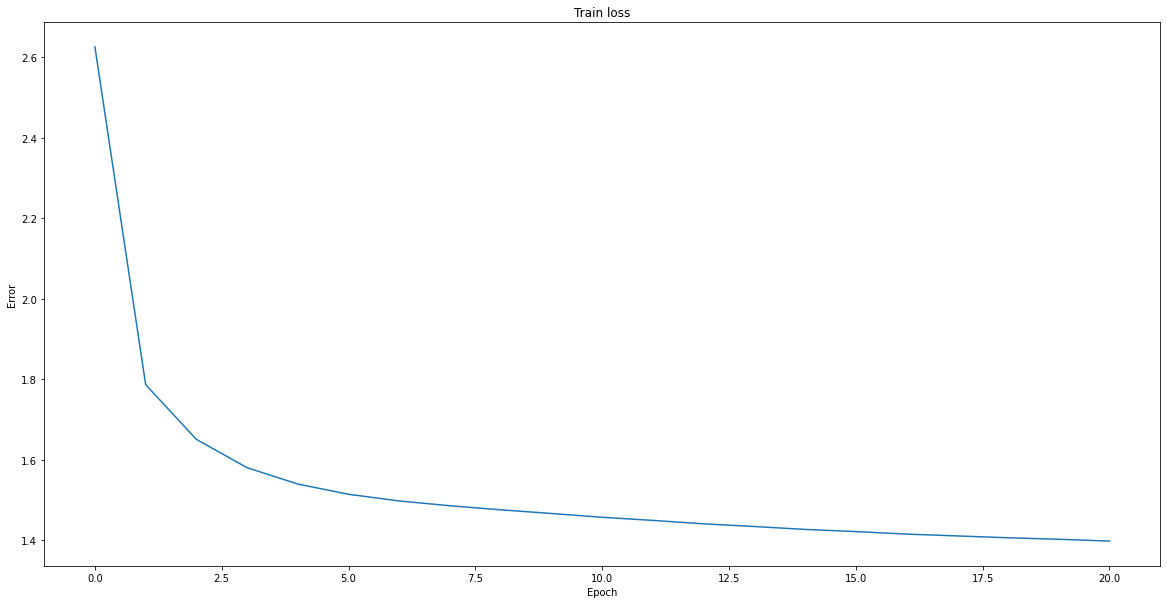

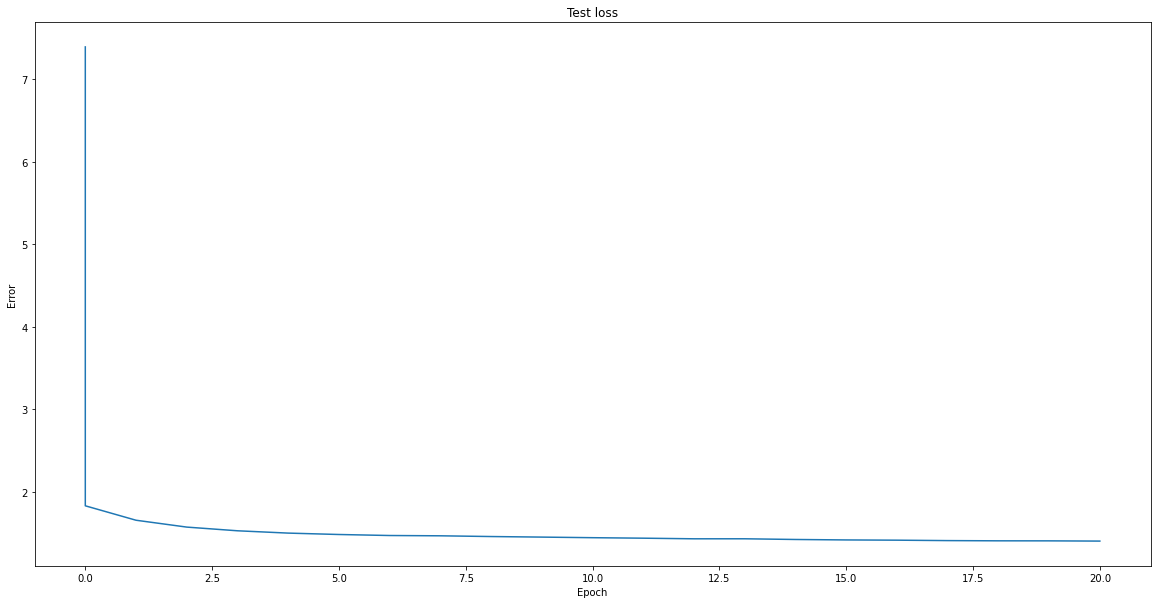

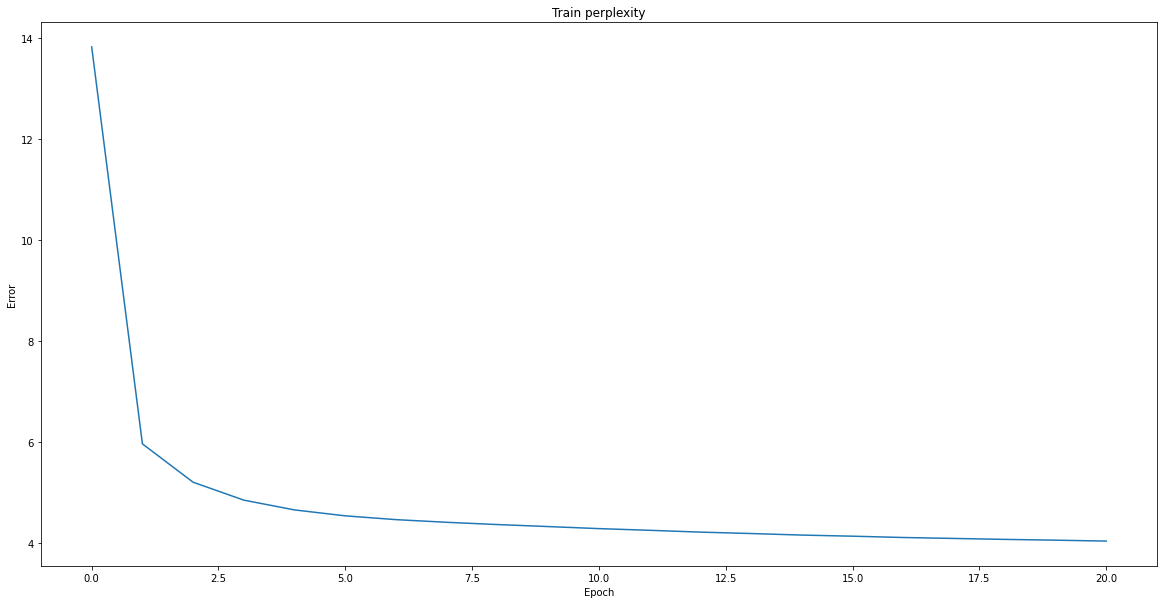

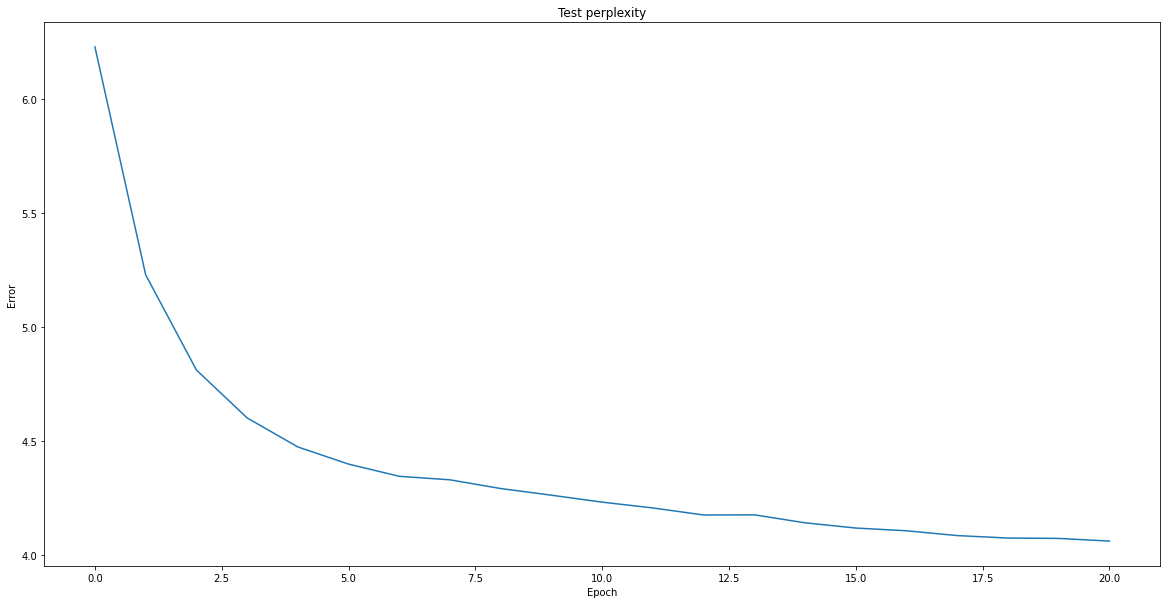

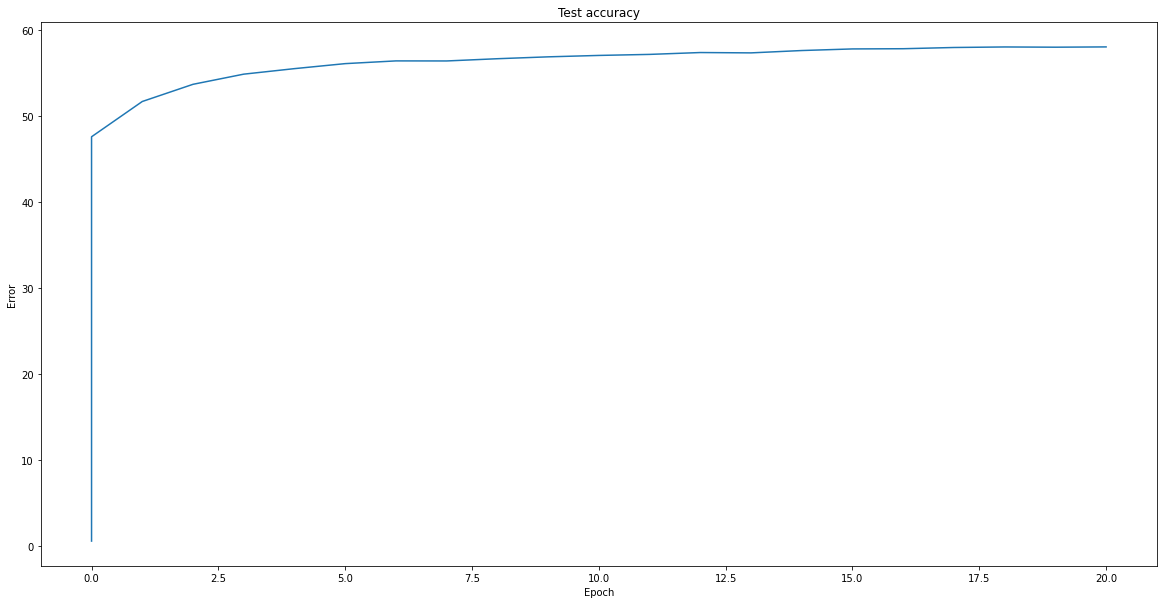

In [15]:
final_model, vocab, device = main()

## Part 8.3: Use LSTM instead of GRU

In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet2(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet2, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state, cell_state):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # h_0 = Variable(torch.zeros(self.feature_size, x.size(0), self.feature_size))
        # c_0 = Variable(torch.zeros(self.feature_size, x.size(0), self.feature_size))
        
        # print("x.size(0)", x.size(0))
        x = self.encoder(x)
        x, output_tuple = self.lstm(x, (hidden_state, cell_state)) # x must have shape (batch, seq, input_size)
        hidden_state = output_tuple[0]
        cell_state = output_tuple[1]
        m = nn.ReLU()
        x = self.decoder(m(x))

        return x, hidden_state, cell_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state, cell_state, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state, cell_state = self.forward(x, hidden_state, cell_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state, cell_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

    # def init_hidden(self, batch_size):
    #     weight = next(self.parameters()).data
    #     hidden = (weight.new(1, batch_size, self.feature_size).zero_().to(device),
    #               weight.new(1, batch_size, self.feature_size).zero_().to(device))
    #     return hidden

In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab):
    outputs = []
    # print("output shape:", output.shape)
    # print("sequence length:", sequence_length)
    # output shape: torch.Size([1, 89])
    # sequence length: 200
    for ii in range(sequence_length):
        # TODO
        max_idx = output[0].argmax()
        outputs.append(max_idx)
        output, hidden, cell_state = model.inference(max_idx, hidden, cell_state)

    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        random_idx = torch.multinomial(output[0], 1)[0]
        outputs.append(random_idx)
        output, hidden, cell_state = model.inference(random_idx, hidden, cell_state)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell_state, vocab):
    outputs = []
    beams = [([], output, hidden, cell_state, 0)]
    # print(output[0])
    '''
    tensor([1.6517e-01, 2.5057e-02, 1.1488e-03, 4.4171e-03, 2.2209e-07, 2.0459e-02,
        1.1283e-02, 3.9707e-03, 5.7665e-03, 2.4277e-03, 1.2907e-03, 6.1842e-03,
        3.4050e-02, 3.3461e-03, 7.2718e-03, 5.9175e-03, 1.0736e-02, 3.3752e-02,
        3.7023e-02, 2.8446e-03, 1.4617e-02, 1.4860e-02, 1.5890e-02, 1.6791e-02,
        9.2171e-03, 5.8036e-02, 8.5500e-03, 5.7428e-02, 1.2578e-03, 1.1423e-02,
        2.1873e-02, 4.5148e-02, 3.2809e-03, 1.2385e-03, 1.2515e-04, 1.6862e-03,
        4.0081e-03, 4.1718e-03, 4.4101e-03, 2.7127e-03, 5.7073e-03, 1.7715e-03,
        1.3188e-03, 2.0458e-04, 1.3358e-03, 3.5202e-03, 6.6162e-03, 6.5361e-04,
        2.3658e-03, 2.6127e-01, 1.6731e-02, 4.2500e-05, 3.0019e-04, 3.7371e-04,
        5.3597e-03, 1.5096e-03, 6.5899e-04, 3.4807e-04, 6.4759e-05, 2.6869e-03,
        3.1628e-03, 5.3389e-05, 5.7146e-04, 4.9546e-04, 3.7386e-05, 6.8254e-06,
        1.4656e-03, 8.9231e-07, 1.6121e-05, 7.6104e-06, 4.7323e-05, 1.0916e-06,
        5.1860e-05, 3.4274e-04, 6.8891e-04, 2.3170e-04, 6.0992e-05, 2.0812e-06,
        8.8466e-06, 6.7174e-06, 3.6912e-05, 1.2406e-05, 1.0939e-04, 4.5623e-04,
        3.0424e-04, 2.5627e-05, 2.8489e-05, 8.6720e-05, 3.8617e-06],
       device='cuda:0')
    '''
    # TODO
    for ii in range(sequence_length):
        new_beams = []
        for beam in beams:
            # Compute the next distribution over the output space for that state
            # if len(beams) == 1:
            #     # output shape: torch.Size([1, 89]), output is an array of probs
            #     x = output# Initial value - not sure of output.shape but it should be based on the original seed_words
            # else:
            #     x = beam[0] # Use the entire sequence so far or just the most recent token
            # probs, hidden = model.inference(x, hidden) # Get probability distribution based on what came before
            # samples = torch.multinomial(output[0], beam_width, replacement=True) # Sample based on the probs

            samples = torch.multinomial(output[0], beam_width, replacement=True)
            for sample in samples:
                log_score = torch.log(beam[1][0][sample]) + beam[4] # Compute score for the sample
                output, hidden, cell_state = model.inference(sample, hidden, cell_state) # Record its hidden state and chosen value
                new_beams.append((beam[0] + [sample], output, hidden, cell_state, log_score))
        # sort by log_score
        new_beams.sort(reverse=True, key=lambda b: b[4])
        beams = new_beams[:beam_width]
    outputs = beams[0][0]

    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        # hidden = None
        # cell_state = None
        hc = init_hidden(model, device, 1)
        hidden = hc[0]
        cell_state = hc[1]
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden, cell_state = model.inference(data, hidden, cell_state)
            # hidden = output_tuple[0]
            # cell_state = output_tuple[1]
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell_state, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

FEATURE_SIZE = 512
X_SIZE_0 = 256
BATCH_SIZE = 256

def init_hidden(model, device, batch_size):
    weight = next(model.parameters()).data
    hidden = (weight.new(1, batch_size, model.feature_size).zero_().to(device),
                weight.new(1, batch_size, model.feature_size).zero_().to(device))
    return hidden

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None # torch.zeros(1, X_SIZE_0, FEATURE_SIZE).to(device)
    cell_state = None # torch.zeros(1, X_SIZE_0, FEATURE_SIZE).to(device)

    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        hc = init_hidden(model, device, BATCH_SIZE)
        hidden = hc[0]
        cell_state = hc[1]
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden, cell_state = model(data, hidden, cell_state)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None # torch.zeros(1, X_SIZE_0, FEATURE_SIZE).to(device)
        cell_state = None # torch.zeros(1, X_SIZE_0, FEATURE_SIZE).to(device)
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            hc = init_hidden(model, device, BATCH_SIZE)
            hidden = hc[0]
            cell_state = hc[1]
            output, hidden, cell_state = model(data, hidden, cell_state)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/000.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat ttlnttnd toaded tnain.t the sare   thsk  "I sm tarr  .  "e said  "Ion't wauky  thtt" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	 ue d the stt r

  1%|          | 2/195 [00:00<00:43,  4.42it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 1.446320


  6%|▌         | 12/195 [00:02<00:35,  5.15it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 1.722199


 11%|█         | 21/195 [00:04<00:35,  4.93it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 1.573873


 16%|█▌        | 31/195 [00:06<00:32,  4.99it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 1.525456


 21%|██        | 41/195 [00:08<00:30,  5.04it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 1.480433


 27%|██▋       | 52/195 [00:10<00:27,  5.17it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 1.452237


 31%|███▏      | 61/195 [00:12<00:26,  5.10it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.452004


 37%|███▋      | 72/195 [00:14<00:24,  5.00it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.444483


 42%|████▏     | 82/195 [00:16<00:22,  5.09it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.423133


 47%|████▋     | 92/195 [00:18<00:20,  5.07it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.435921


 52%|█████▏    | 102/195 [00:20<00:18,  5.02it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.438987


 57%|█████▋    | 111/195 [00:22<00:16,  5.11it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.419989


 62%|██████▏   | 121/195 [00:24<00:14,  5.13it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.435537


 68%|██████▊   | 132/195 [00:26<00:12,  5.06it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.449129


 72%|███████▏  | 141/195 [00:27<00:10,  4.99it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.438447


 77%|███████▋  | 151/195 [00:30<00:08,  4.97it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.431458


 83%|████████▎ | 162/195 [00:32<00:06,  5.01it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.418319


 88%|████████▊ | 172/195 [00:34<00:04,  5.01it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.413332


 93%|█████████▎| 181/195 [00:36<00:02,  4.95it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.410977


 98%|█████████▊| 192/195 [00:38<00:00,  4.99it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.420517


100%|██████████| 195/195 [00:38<00:00,  5.03it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat ttlnttnd soanid tnain,t the mase   aask  "I ws aarr  .  "e said  "Ion't warky  tot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	 us s toe mtt r oore  and tarry saap d tumbledore wuck tn o the cne otetnrer ahat horl d the saoaent


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd soanpeng tn the cogdle of the cork aash hnauet an tagsmeade  "or sf  oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:06,  2.93it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.434090


  6%|▌         | 11/195 [00:02<00:37,  4.86it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.448321


 11%|█▏        | 22/195 [00:04<00:34,  5.00it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.436131


 16%|█▌        | 31/195 [00:06<00:32,  4.97it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.438112


 21%|██        | 41/195 [00:08<00:30,  5.05it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.420499


 27%|██▋       | 52/195 [00:10<00:28,  5.03it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.410621


 32%|███▏      | 62/195 [00:12<00:26,  5.08it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.417618


 37%|███▋      | 72/195 [00:14<00:24,  5.03it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.412682


 42%|████▏     | 82/195 [00:16<00:22,  5.07it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.404825


 47%|████▋     | 92/195 [00:18<00:20,  4.94it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.415685


 52%|█████▏    | 101/195 [00:20<00:18,  5.03it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.426084


 57%|█████▋    | 111/195 [00:22<00:16,  5.02it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.407032


 62%|██████▏   | 121/195 [00:24<00:14,  5.02it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.417172


 67%|██████▋   | 131/195 [00:26<00:12,  4.93it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.424638


 73%|███████▎  | 142/195 [00:28<00:10,  5.01it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.434453


 77%|███████▋  | 151/195 [00:30<00:08,  4.99it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.434271


 83%|████████▎ | 161/195 [00:32<00:06,  4.89it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.406877


 88%|████████▊ | 171/195 [00:34<00:04,  4.97it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.395150


 93%|█████████▎| 181/195 [00:36<00:02,  5.06it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.399806


 98%|█████████▊| 192/195 [00:38<00:00,  4.97it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.405879


100%|██████████| 195/195 [00:39<00:00,  4.98it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat stlntand soasid tnainst the sase   aasl  "I wl tarr  .  "e said  "Ion't sarky "Iat," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	 ut d the stt n oame  and tarry saaded tumbledore weck tn o the sne waet red ahet horl d the saoaeni


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd sianpeng hn the sagdle of the sork aash hnauet an tagwmeade  "or tfe oalrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:04,  2.99it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.424411


  6%|▌         | 12/195 [00:02<00:37,  4.83it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.420209


 11%|█▏        | 22/195 [00:04<00:34,  5.04it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.411542


 16%|█▌        | 31/195 [00:06<00:32,  4.98it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.420116


 21%|██        | 41/195 [00:08<00:30,  5.05it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.409977


 26%|██▌       | 51/195 [00:10<00:29,  4.88it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.392896


 32%|███▏      | 62/195 [00:12<00:26,  5.01it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.414279


 36%|███▋      | 71/195 [00:14<00:24,  5.07it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.406800


 42%|████▏     | 82/195 [00:16<00:22,  5.05it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.393300


 47%|████▋     | 92/195 [00:18<00:20,  5.10it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.401029


 52%|█████▏    | 102/195 [00:20<00:18,  5.03it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.408575


 57%|█████▋    | 111/195 [00:22<00:16,  5.01it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.396573


 63%|██████▎   | 122/195 [00:24<00:14,  4.99it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.408745


 68%|██████▊   | 132/195 [00:26<00:12,  5.06it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.418226


 72%|███████▏  | 141/195 [00:28<00:10,  5.02it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.415363


 77%|███████▋  | 151/195 [00:30<00:08,  4.96it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.415288


 83%|████████▎ | 162/195 [00:32<00:06,  5.01it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.395373


 88%|████████▊ | 171/195 [00:34<00:04,  4.99it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.389883


 93%|█████████▎| 181/195 [00:36<00:02,  5.07it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.386377


 98%|█████████▊| 192/195 [00:38<00:00,  5.00it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.396635


100%|██████████| 195/195 [00:39<00:00,  4.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat htlntond soasid t ain,t the sare  oaasl  "I wl tarr  .  "e said  "Ion't warky  Iot,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oame  and tarry saad d tumbledore weck tn o the sne wter yed ahet hrrl d ahe saoaeoi


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sian eng hn the saddle of the serk aash hnuuet an tagwmeade  "or ane oaurible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:04,  2.99it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.417593


  6%|▌         | 11/195 [00:02<00:38,  4.76it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.415163


 11%|█▏        | 22/195 [00:04<00:34,  5.07it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.405096


 16%|█▌        | 31/195 [00:06<00:32,  5.03it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.415597


 21%|██        | 41/195 [00:08<00:30,  5.03it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.402215


 27%|██▋       | 52/195 [00:10<00:28,  4.98it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.389765


 32%|███▏      | 62/195 [00:12<00:26,  5.01it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.406004


 37%|███▋      | 72/195 [00:14<00:24,  5.03it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.395889


 42%|████▏     | 81/195 [00:16<00:22,  4.96it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.391890


 47%|████▋     | 92/195 [00:18<00:20,  5.01it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.400870


 52%|█████▏    | 101/195 [00:20<00:18,  5.06it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.407600


 57%|█████▋    | 111/195 [00:22<00:17,  4.93it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.387223


 63%|██████▎   | 122/195 [00:24<00:14,  5.05it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.404274


 68%|██████▊   | 132/195 [00:26<00:12,  4.97it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.411694


 73%|███████▎  | 142/195 [00:28<00:10,  4.99it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.411102


 78%|███████▊  | 152/195 [00:30<00:08,  4.93it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.402161


 83%|████████▎ | 162/195 [00:32<00:06,  4.96it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.381905


 88%|████████▊ | 171/195 [00:34<00:04,  5.03it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.382281


 93%|█████████▎| 181/195 [00:36<00:02,  5.03it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.383153


 98%|█████████▊| 192/195 [00:38<00:00,  5.04it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.395251


100%|██████████| 195/195 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat stlntond soasid a ain t the sare  oaasl  "I wl tirr  .  "e said  "Ion't warky  Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oame  and tarry saaded tumbledore weck tn o the snr wter yed,ahat hrrl d ahe saoaelt


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sian eng hn the saddle of the sark aagh anuyet an tagw eade  "or afe oaurible aarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:04,  3.02it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.414518


  6%|▌         | 11/195 [00:02<00:38,  4.75it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.410081


 11%|█▏        | 22/195 [00:04<00:34,  5.08it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.409490


 16%|█▌        | 31/195 [00:06<00:32,  5.02it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.404670


 21%|██        | 41/195 [00:08<00:30,  4.97it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.394822


 27%|██▋       | 52/195 [00:10<00:28,  5.05it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.385199


 32%|███▏      | 62/195 [00:12<00:26,  5.02it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.404304


 37%|███▋      | 72/195 [00:14<00:24,  5.01it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.395338


 42%|████▏     | 82/195 [00:16<00:22,  4.94it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.380370


 47%|████▋     | 92/195 [00:18<00:20,  5.03it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.393879


 52%|█████▏    | 101/195 [00:20<00:18,  5.02it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.410535


 57%|█████▋    | 111/195 [00:22<00:16,  4.95it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.388079


 63%|██████▎   | 122/195 [00:24<00:14,  5.02it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.399090


 67%|██████▋   | 131/195 [00:26<00:12,  4.93it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.415614


 72%|███████▏  | 141/195 [00:28<00:10,  5.00it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.407048


 78%|███████▊  | 152/195 [00:30<00:08,  4.97it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.395342


 83%|████████▎ | 162/195 [00:32<00:06,  4.97it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.378617


 88%|████████▊ | 171/195 [00:34<00:04,  5.03it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.375644


 93%|█████████▎| 181/195 [00:36<00:02,  5.04it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.377270


 98%|█████████▊| 192/195 [00:38<00:00,  5.00it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.391063


100%|██████████| 195/195 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat selntond soased a ain t the sare  oaasl  "I wl terr, .  "e said  "Iun't warky  Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oame  and tarry saaded tumbledore weck tn o the snk weer red ahan harl d the saoael 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d saan eng tn the saddle of the sark aagh anayet an tagw eade  "or afe oaurible aarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:08,  2.82it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.412579


  6%|▌         | 11/195 [00:02<00:37,  4.85it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.398043


 11%|█▏        | 22/195 [00:04<00:34,  4.98it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.398293


 16%|█▌        | 31/195 [00:06<00:32,  5.03it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.398907


 22%|██▏       | 42/195 [00:08<00:30,  5.01it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.397017


 27%|██▋       | 52/195 [00:10<00:28,  5.04it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.375314


 32%|███▏      | 62/195 [00:12<00:26,  5.01it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.398337


 37%|███▋      | 72/195 [00:14<00:25,  4.92it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.391138


 42%|████▏     | 81/195 [00:16<00:22,  5.02it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.375309


 47%|████▋     | 91/195 [00:18<00:20,  4.99it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.390952


 52%|█████▏    | 102/195 [00:20<00:18,  5.02it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.397213


 57%|█████▋    | 111/195 [00:22<00:16,  5.01it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.377638


 63%|██████▎   | 122/195 [00:24<00:14,  5.01it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.395383


 68%|██████▊   | 132/195 [00:26<00:12,  5.02it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.403057


 73%|███████▎  | 142/195 [00:28<00:10,  4.98it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.401902


 77%|███████▋  | 151/195 [00:30<00:08,  5.06it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.391342


 83%|████████▎ | 161/195 [00:32<00:06,  4.91it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.376967


 88%|████████▊ | 171/195 [00:34<00:04,  5.01it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.376835


 93%|█████████▎| 181/195 [00:36<00:02,  4.93it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.376087


 98%|█████████▊| 192/195 [00:38<00:00,  5.04it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.393954


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat atlntond soadid ttain,t the sare  oaasl  "I dl terri .  "e said  "Iun't tarky  tot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oame  tnd tarry aaaded tumbledore weck tn o the snr oeet redsahan hrrl d the saoaeni


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and soanpeng tn the saddle of the cork aagh anauet an tagwteade  "or tfe oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:07,  2.89it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.406355


  6%|▌         | 11/195 [00:02<00:38,  4.81it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.396824


 11%|█▏        | 22/195 [00:04<00:34,  4.95it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.391431


 16%|█▋        | 32/195 [00:06<00:32,  5.05it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.398627


 21%|██        | 41/195 [00:08<00:30,  5.12it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.390346


 27%|██▋       | 52/195 [00:10<00:28,  5.02it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.370093


 32%|███▏      | 62/195 [00:12<00:26,  5.04it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.394878


 37%|███▋      | 72/195 [00:14<00:24,  4.98it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.385865


 42%|████▏     | 81/195 [00:16<00:22,  4.98it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.375983


 47%|████▋     | 91/195 [00:18<00:21,  4.94it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.388493


 52%|█████▏    | 102/195 [00:20<00:18,  5.03it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.393583


 57%|█████▋    | 111/195 [00:22<00:16,  5.14it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.369511


 62%|██████▏   | 121/195 [00:24<00:14,  5.11it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.391522


 68%|██████▊   | 132/195 [00:26<00:12,  5.05it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.400405


 73%|███████▎  | 142/195 [00:28<00:10,  5.01it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.406755


 77%|███████▋  | 151/195 [00:30<00:08,  5.04it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.391500


 83%|████████▎ | 162/195 [00:32<00:06,  4.96it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.371720


 88%|████████▊ | 171/195 [00:34<00:04,  5.03it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.374827


 93%|█████████▎| 181/195 [00:36<00:02,  4.97it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.368249


 98%|█████████▊| 191/195 [00:38<00:00,  4.99it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.381530


100%|██████████| 195/195 [00:39<00:00,  4.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeet atlnttnd soadid a ain.t the sare  oaanl  "I dl ahrri .  "e said  "Iun't tarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oare  tnd tarry saaded tumbledore weck tn o the snr oeet redsahan hrrl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng tn the saddle of the sark aagh anauet an tagw eade  "or tne oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:05,  2.95it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.400377


  6%|▌         | 11/195 [00:02<00:39,  4.70it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.390740


 11%|█▏        | 22/195 [00:04<00:34,  4.98it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.391767


 16%|█▌        | 31/195 [00:06<00:32,  5.06it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.398638


 21%|██        | 41/195 [00:08<00:30,  5.05it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.380509


 26%|██▌       | 51/195 [00:10<00:29,  4.93it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.369063


 31%|███▏      | 61/195 [00:12<00:26,  5.01it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.388745


 36%|███▋      | 71/195 [00:14<00:25,  4.93it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.384327


 42%|████▏     | 81/195 [00:16<00:22,  5.00it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.372658


 47%|████▋     | 91/195 [00:18<00:21,  4.94it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.381816


 52%|█████▏    | 101/195 [00:20<00:18,  5.01it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.392419


 57%|█████▋    | 111/195 [00:22<00:16,  5.00it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.368808


 63%|██████▎   | 122/195 [00:24<00:14,  5.04it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.387119


 68%|██████▊   | 132/195 [00:26<00:12,  5.02it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.398248


 73%|███████▎  | 142/195 [00:28<00:10,  4.96it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.396403


 77%|███████▋  | 151/195 [00:30<00:08,  4.98it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.387301


 83%|████████▎ | 162/195 [00:32<00:06,  4.98it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.370570


 88%|████████▊ | 171/195 [00:34<00:04,  5.00it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.380209


 93%|█████████▎| 181/195 [00:36<00:02,  5.03it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.365321


 98%|█████████▊| 192/195 [00:38<00:00,  5.02it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.378893


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeet stlntond soaded anain.t the sare  oaasl  "I dl aerri .  "e said  "Iun't warky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oane  tnd tarry saaded tumbledore weck tn o the snr otet redsahan hrrl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianpeng tn the saddle of the sark aagh anauet an tagwmeade  "or afe oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:06,  2.90it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.396549


  6%|▌         | 12/195 [00:02<00:37,  4.94it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.390106


 11%|█▏        | 22/195 [00:04<00:34,  5.05it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.387185


 16%|█▌        | 31/195 [00:06<00:32,  5.07it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.397974


 21%|██        | 41/195 [00:08<00:30,  5.07it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.379923


 27%|██▋       | 52/195 [00:10<00:28,  4.95it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.363243


 32%|███▏      | 62/195 [00:12<00:26,  5.02it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.381538


 36%|███▋      | 71/195 [00:14<00:24,  5.01it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.375106


 42%|████▏     | 82/195 [00:16<00:22,  4.99it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.364600


 47%|████▋     | 91/195 [00:18<00:21,  4.95it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.373953


 52%|█████▏    | 101/195 [00:20<00:18,  5.02it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.384882


 57%|█████▋    | 111/195 [00:22<00:16,  5.06it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.371066


 63%|██████▎   | 122/195 [00:24<00:14,  5.02it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.384378


 68%|██████▊   | 132/195 [00:26<00:12,  5.03it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.394178


 72%|███████▏  | 141/195 [00:28<00:10,  5.03it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.395865


 78%|███████▊  | 152/195 [00:30<00:08,  4.99it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.385546


 83%|████████▎ | 162/195 [00:32<00:06,  5.02it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.366714


 88%|████████▊ | 171/195 [00:34<00:04,  4.89it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.364209


 93%|█████████▎| 181/195 [00:36<00:02,  5.03it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.362193


 98%|█████████▊| 192/195 [00:38<00:00,  4.99it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.374748


100%|██████████| 195/195 [00:39<00:00,  4.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat stlntond soaddd ttain.t the sase  oaasl  "I dl ahlri .  "e said  "Iun't tarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oame  tnd tarry saaded tumbledore weck tn o the snr otet redsahan hrrl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d seanpeng tn the saddle of the sark aagh anauet an tagwmeade  "or tne oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:04,  2.99it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.390459


  6%|▌         | 11/195 [00:02<00:38,  4.77it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.387570


 11%|█▏        | 22/195 [00:04<00:34,  4.95it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.385082


 16%|█▌        | 31/195 [00:06<00:32,  5.02it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.391579


 21%|██        | 41/195 [00:08<00:30,  5.00it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.372014


 27%|██▋       | 52/195 [00:10<00:28,  5.05it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.360083


 31%|███▏      | 61/195 [00:12<00:27,  4.93it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.384362


 37%|███▋      | 72/195 [00:14<00:24,  5.04it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.373981


 42%|████▏     | 81/195 [00:16<00:23,  4.84it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.364420


 47%|████▋     | 92/195 [00:18<00:20,  5.01it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.375842


 52%|█████▏    | 101/195 [00:20<00:18,  5.03it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.381145


 57%|█████▋    | 111/195 [00:22<00:17,  4.91it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.364354


 63%|██████▎   | 122/195 [00:24<00:14,  5.06it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.383012


 68%|██████▊   | 132/195 [00:26<00:12,  4.97it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.388534


 73%|███████▎  | 142/195 [00:28<00:10,  5.06it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.389466


 78%|███████▊  | 152/195 [00:30<00:08,  5.00it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.380175


 83%|████████▎ | 162/195 [00:32<00:06,  4.97it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.361826


 88%|████████▊ | 171/195 [00:34<00:04,  5.02it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.368812


 93%|█████████▎| 181/195 [00:36<00:02,  4.99it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.364448


 98%|█████████▊| 192/195 [00:38<00:00,  5.05it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.375141


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat stlntond soaddd t ainst the sase  ooasl  "I dl aerri .  "e said  "Iun't warky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oame  tnd tarry saaded tumbledore weck tn o the snr oeet redsthan hrrl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianpeng tn the saddle of the sark aagh anauet an tagw eade  "or tne oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:07,  2.89it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.388461


  6%|▌         | 11/195 [00:02<00:38,  4.75it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.386306


 11%|█▏        | 22/195 [00:04<00:34,  5.03it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.381180


 16%|█▌        | 31/195 [00:06<00:32,  5.09it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.383472


 21%|██        | 41/195 [00:08<00:30,  4.99it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.371859


 27%|██▋       | 52/195 [00:10<00:28,  5.04it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.359246


 31%|███▏      | 61/195 [00:12<00:26,  5.02it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.382265


 36%|███▋      | 71/195 [00:14<00:24,  5.05it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.371071


 42%|████▏     | 81/195 [00:16<00:23,  4.90it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.359948


 47%|████▋     | 91/195 [00:18<00:20,  4.96it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.372258


 52%|█████▏    | 101/195 [00:20<00:18,  5.00it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.380180


 57%|█████▋    | 111/195 [00:22<00:16,  4.97it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.366290


 63%|██████▎   | 122/195 [00:24<00:14,  4.91it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.374930


 68%|██████▊   | 132/195 [00:26<00:12,  4.97it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.386527


 72%|███████▏  | 141/195 [00:28<00:10,  4.99it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.387926


 78%|███████▊  | 152/195 [00:30<00:08,  5.03it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.376669


 83%|████████▎ | 162/195 [00:32<00:06,  4.98it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.362399


 88%|████████▊ | 171/195 [00:34<00:04,  5.02it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.364276


 93%|█████████▎| 181/195 [00:36<00:02,  5.01it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.358724


 98%|█████████▊| 192/195 [00:38<00:00,  4.97it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.372152


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat selntond soaddd ttain,t the sase  oaasl  "I dl aelri .  "e said  "Iun't warky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt n oome  tnd tarry saaded tumbledore weck tn o the snr oeet yedsthan hrrl d toe saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and seanpeng tn the saddle of the sark aagh anauet an tagw eade  "or ane oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:09,  2.79it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.388187


  6%|▌         | 11/195 [00:02<00:38,  4.81it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.383165


 11%|█         | 21/195 [00:04<00:35,  4.97it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.384000


 16%|█▋        | 32/195 [00:06<00:31,  5.10it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.383632


 21%|██        | 41/195 [00:08<00:31,  4.96it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.366944


 26%|██▌       | 51/195 [00:10<00:29,  4.92it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.353055


 32%|███▏      | 62/195 [00:12<00:26,  5.05it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.375285


 37%|███▋      | 72/195 [00:14<00:24,  4.98it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.370602


 42%|████▏     | 81/195 [00:16<00:22,  5.03it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.358864


 47%|████▋     | 92/195 [00:18<00:20,  4.93it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.365655


 52%|█████▏    | 101/195 [00:20<00:18,  5.01it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.373804


 57%|█████▋    | 111/195 [00:22<00:16,  5.04it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.357144


 63%|██████▎   | 122/195 [00:24<00:14,  5.02it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.375448


 68%|██████▊   | 132/195 [00:26<00:12,  5.00it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.383425


 73%|███████▎  | 142/195 [00:28<00:10,  4.96it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.382054


 77%|███████▋  | 151/195 [00:30<00:08,  4.96it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.375399


 83%|████████▎ | 161/195 [00:32<00:06,  4.91it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.362219


 88%|████████▊ | 171/195 [00:34<00:04,  5.05it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.358804


 93%|█████████▎| 181/195 [00:36<00:02,  5.03it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.367041


 98%|█████████▊| 192/195 [00:38<00:00,  5.04it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.374686


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeet stlntond soadid ttainst the sase  oaasl. "I dl aerri .  "e said  "Iun't tarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt n oome  and tarry saaded tumbledore weck tn o the snk oeet yed.toat hrrled the saoaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and seanpeng tn the saddle of the sark aagh anauet an tagwmeade  "or ane oeurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:05,  2.97it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.384210


  6%|▌         | 12/195 [00:02<00:37,  4.84it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.379773


 11%|█▏        | 22/195 [00:04<00:34,  4.99it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.372953


 16%|█▋        | 32/195 [00:06<00:32,  4.99it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.380051


 21%|██        | 41/195 [00:08<00:31,  4.97it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.367087


 26%|██▌       | 51/195 [00:10<00:28,  5.02it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.354117


 32%|███▏      | 62/195 [00:12<00:26,  5.04it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.369983


 37%|███▋      | 72/195 [00:14<00:24,  5.00it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.366528


 42%|████▏     | 82/195 [00:16<00:22,  4.98it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.357471


 47%|████▋     | 92/195 [00:18<00:20,  4.98it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.365799


 52%|█████▏    | 101/195 [00:20<00:19,  4.92it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.372260


 57%|█████▋    | 111/195 [00:22<00:16,  5.03it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.362889


 63%|██████▎   | 122/195 [00:24<00:14,  5.00it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.374091


 68%|██████▊   | 132/195 [00:26<00:12,  5.02it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.383032


 73%|███████▎  | 142/195 [00:28<00:10,  5.00it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.384398


 77%|███████▋  | 151/195 [00:30<00:08,  4.96it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.378135


 83%|████████▎ | 162/195 [00:32<00:06,  4.98it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.360129


 88%|████████▊ | 172/195 [00:34<00:04,  5.04it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.352838


 93%|█████████▎| 181/195 [00:36<00:02,  5.01it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.356397


 98%|█████████▊| 191/195 [00:38<00:00,  5.07it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.366091


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat stlntond soavid ttain.t the sase  otasl  "I dl aelri".  "e said  "Iun't sarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt n oome  tnd tarry saaded tumbledore weck tn o the snt oeet yed.that srrled the saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sianpeng tn the saddle of the sark oagh anueet an tagw eade  "or tne oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:07,  2.89it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.380956


  6%|▌         | 11/195 [00:02<00:38,  4.79it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.378670


 11%|█▏        | 22/195 [00:04<00:34,  4.99it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.378843


 16%|█▌        | 31/195 [00:06<00:32,  5.05it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.381695


 21%|██        | 41/195 [00:08<00:30,  5.06it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.361633


 27%|██▋       | 52/195 [00:10<00:28,  5.07it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.352245


 31%|███▏      | 61/195 [00:12<00:26,  5.10it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.367605


 37%|███▋      | 72/195 [00:14<00:24,  5.09it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.365127


 42%|████▏     | 82/195 [00:16<00:22,  5.02it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.352921


 47%|████▋     | 92/195 [00:18<00:20,  5.00it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.362162


 52%|█████▏    | 102/195 [00:20<00:18,  5.01it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.373241


 57%|█████▋    | 111/195 [00:22<00:16,  5.05it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.358035


 63%|██████▎   | 122/195 [00:24<00:14,  4.96it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.371447


 67%|██████▋   | 131/195 [00:26<00:12,  5.06it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.382683


 72%|███████▏  | 141/195 [00:28<00:10,  5.00it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.380827


 78%|███████▊  | 152/195 [00:30<00:08,  5.06it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.372065


 83%|████████▎ | 161/195 [00:32<00:06,  4.97it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.357919


 88%|████████▊ | 172/195 [00:34<00:04,  4.97it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.350350


 93%|█████████▎| 181/195 [00:36<00:02,  5.00it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.354776


 98%|█████████▊| 192/195 [00:38<00:00,  4.99it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.366219


100%|██████████| 195/195 [00:39<00:00,  4.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeat stlntond soasid ttainst the sase  otasl. "I sl aelri".  "e said  "Iun't warry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt n oome  and tarry saaded tumbledore weck tn o the snt oiet yed.than horl d the saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng tn the saddle of the sark oagh anaeet an tagwmeade  "ir tne oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:06,  2.91it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.379795


  6%|▌         | 12/195 [00:02<00:37,  4.90it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.378852


 11%|█▏        | 22/195 [00:04<00:34,  5.02it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.376512


 16%|█▌        | 31/195 [00:06<00:32,  5.00it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.379896


 21%|██        | 41/195 [00:08<00:30,  5.11it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.364561


 27%|██▋       | 52/195 [00:10<00:28,  5.00it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.352883


 32%|███▏      | 62/195 [00:12<00:26,  5.02it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.371349


 36%|███▋      | 71/195 [00:14<00:24,  5.12it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.360468


 42%|████▏     | 82/195 [00:16<00:22,  5.03it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.354081


 47%|████▋     | 92/195 [00:18<00:20,  5.00it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.361313


 52%|█████▏    | 101/195 [00:20<00:18,  5.02it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.369646


 57%|█████▋    | 111/195 [00:22<00:16,  4.99it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.352973


 63%|██████▎   | 122/195 [00:24<00:14,  4.98it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.368418


 67%|██████▋   | 131/195 [00:26<00:12,  4.97it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.381328


 72%|███████▏  | 141/195 [00:28<00:10,  4.95it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.385208


 78%|███████▊  | 152/195 [00:30<00:08,  4.99it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.373101


 83%|████████▎ | 162/195 [00:32<00:06,  4.99it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.352775


 88%|████████▊ | 172/195 [00:34<00:04,  5.01it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.352158


 93%|█████████▎| 181/195 [00:36<00:02,  5.09it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.351247


 98%|█████████▊| 192/195 [00:38<00:00,  5.02it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.364537


100%|██████████| 195/195 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat stlntond soavid ttain.t the sase  atasl  "I sl aelri".  "e said  "Iun't yarry  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oome  and tarry saaded humbledore weck tn o the snt oeet yed that horled the saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng hn the saddle of the sark aagh anaeet an tagwmeade  "or ane oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:04,  3.00it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.376890


  6%|▌         | 12/195 [00:02<00:38,  4.81it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.376905


 11%|█▏        | 22/195 [00:04<00:34,  5.06it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.371868


 16%|█▌        | 31/195 [00:06<00:32,  5.10it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.373283


 21%|██        | 41/195 [00:08<00:30,  5.01it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.359922


 27%|██▋       | 52/195 [00:10<00:28,  5.00it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.348893


 32%|███▏      | 62/195 [00:12<00:26,  5.06it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.367165


 37%|███▋      | 72/195 [00:14<00:24,  5.01it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.369075


 42%|████▏     | 82/195 [00:16<00:22,  5.03it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.348489


 47%|████▋     | 92/195 [00:18<00:20,  4.96it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.360057


 52%|█████▏    | 101/195 [00:20<00:18,  5.04it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.370389


 57%|█████▋    | 111/195 [00:22<00:16,  4.99it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.354567


 63%|██████▎   | 122/195 [00:24<00:14,  5.04it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.366309


 67%|██████▋   | 131/195 [00:26<00:12,  4.96it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.377449


 73%|███████▎  | 142/195 [00:28<00:10,  5.04it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.377395


 77%|███████▋  | 151/195 [00:30<00:08,  4.94it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.370458


 83%|████████▎ | 162/195 [00:32<00:06,  4.97it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.353446


 88%|████████▊ | 171/195 [00:34<00:04,  5.10it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.349420


 93%|█████████▎| 181/195 [00:36<00:02,  5.01it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.354358


 98%|█████████▊| 192/195 [00:38<00:00,  5.04it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.360978


100%|██████████| 195/195 [00:39<00:00,  4.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat selntond soavid ttain.t the sase  atasl, "I tl ahlri .  "e said  "Iun't yarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oore  and tarry saaded tumbledore weck tn o the cnt otet red that horled the saoaelh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng hn the saddle of the sark aagh anaeet an tagwteade  "on tne oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:05,  2.94it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.375739


  6%|▌         | 11/195 [00:02<00:38,  4.82it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.375113


 11%|█▏        | 22/195 [00:04<00:35,  4.92it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.366941


 16%|█▌        | 31/195 [00:06<00:32,  5.02it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.373765


 21%|██        | 41/195 [00:08<00:31,  4.96it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.360106


 27%|██▋       | 52/195 [00:10<00:28,  4.98it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.347030


 31%|███▏      | 61/195 [00:12<00:26,  5.01it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.366098


 37%|███▋      | 72/195 [00:14<00:24,  5.04it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.357684


 42%|████▏     | 82/195 [00:16<00:22,  5.03it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.354954


 47%|████▋     | 92/195 [00:18<00:20,  5.05it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.363491


 52%|█████▏    | 101/195 [00:20<00:18,  4.95it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.364560


 57%|█████▋    | 111/195 [00:22<00:17,  4.94it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.348213


 63%|██████▎   | 122/195 [00:24<00:14,  5.03it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.362439


 67%|██████▋   | 131/195 [00:26<00:12,  5.01it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.376851


 72%|███████▏  | 141/195 [00:28<00:11,  4.91it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.375197


 78%|███████▊  | 152/195 [00:30<00:08,  4.97it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.370299


 83%|████████▎ | 162/195 [00:32<00:06,  5.02it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.352634


 88%|████████▊ | 171/195 [00:34<00:04,  4.99it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.348083


 93%|█████████▎| 181/195 [00:36<00:02,  5.00it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.346643


 98%|█████████▊| 192/195 [00:38<00:00,  4.99it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.360933


100%|██████████| 195/195 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat stlntond soadid ttainst the sase  atasl  "I dl ahlri".  "e said  "Iun't yarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oore  and tarry saaded humbledore seck tn o the snt otet yed that horled the sooaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng hn the saddle of the sork aagh anueet an tagwmeade  "or tne oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:10,  2.74it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.374385


  6%|▌         | 11/195 [00:02<00:38,  4.84it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.371521


 11%|█         | 21/195 [00:04<00:35,  4.92it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.366917


 16%|█▋        | 32/195 [00:06<00:32,  4.99it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.376595


 21%|██        | 41/195 [00:08<00:30,  5.02it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.358995


 26%|██▌       | 51/195 [00:10<00:28,  5.02it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.351823


 32%|███▏      | 62/195 [00:12<00:26,  5.01it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.363356


 37%|███▋      | 72/195 [00:14<00:24,  4.98it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.365729


 42%|████▏     | 81/195 [00:16<00:22,  5.03it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.347194


 47%|████▋     | 91/195 [00:18<00:20,  4.96it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.363134


 52%|█████▏    | 101/195 [00:20<00:18,  5.00it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.365315


 57%|█████▋    | 111/195 [00:22<00:16,  5.02it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.344523


 62%|██████▏   | 121/195 [00:24<00:14,  5.00it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.363521


 68%|██████▊   | 132/195 [00:26<00:12,  4.99it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.376314


 72%|███████▏  | 141/195 [00:28<00:10,  4.94it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.371396


 77%|███████▋  | 151/195 [00:30<00:08,  5.04it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.370710


 83%|████████▎ | 161/195 [00:32<00:06,  4.95it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.349388


 88%|████████▊ | 171/195 [00:34<00:04,  5.02it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.344746


 93%|█████████▎| 181/195 [00:36<00:02,  4.97it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.349322


 98%|█████████▊| 192/195 [00:38<00:00,  5.01it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.360671


100%|██████████| 195/195 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat selntond soavid ttainst the sase  aaasl  "I tl ahlri".  "e said  "Iun't yarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oore  tnd tarry saaded humbledore weck tn o the snt oiet red that horled the sooaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng hn the saddle of the sork aagh anueet an tagwmeade  "or tne oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:07,  2.89it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.370705


  6%|▌         | 11/195 [00:02<00:38,  4.78it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.368763


 11%|█         | 21/195 [00:04<00:35,  4.94it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.363395


 16%|█▋        | 32/195 [00:06<00:32,  5.03it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.370727


 21%|██        | 41/195 [00:08<00:30,  5.00it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.357974


 26%|██▌       | 51/195 [00:10<00:28,  5.05it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.346214


 32%|███▏      | 62/195 [00:12<00:26,  4.99it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.360475


 37%|███▋      | 72/195 [00:14<00:24,  5.02it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.359832


 42%|████▏     | 81/195 [00:16<00:22,  5.02it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.344848


 47%|████▋     | 92/195 [00:18<00:20,  4.99it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.359731


 52%|█████▏    | 102/195 [00:20<00:18,  4.97it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.364049


 57%|█████▋    | 111/195 [00:22<00:16,  5.03it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.345111


 63%|██████▎   | 122/195 [00:24<00:14,  4.99it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.361123


 67%|██████▋   | 131/195 [00:26<00:12,  4.99it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.377981


 72%|███████▏  | 141/195 [00:28<00:10,  4.98it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.373018


 78%|███████▊  | 152/195 [00:30<00:08,  5.00it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.365461


 83%|████████▎ | 162/195 [00:32<00:06,  4.99it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.357145


 88%|████████▊ | 172/195 [00:34<00:04,  5.02it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.346013


 93%|█████████▎| 181/195 [00:36<00:02,  5.02it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.344693


 98%|█████████▊| 192/195 [00:38<00:00,  5.01it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.357971


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat stlntond soavid ttain.t the sase  aoask  "I dl selri".  "e said  "Iun't yarky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oore  and tarry saaded humbledore weck tn o the snt otet yed.toat horled the saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d sianpeng hn the saddle of the sark aagh anueet an tagwmeade  "on tne oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:07,  2.89it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.375926


  6%|▌         | 11/195 [00:02<00:37,  4.85it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.375292


 11%|█         | 21/195 [00:04<00:35,  4.87it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.363379


 16%|█▋        | 32/195 [00:06<00:32,  5.04it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.374655


 21%|██        | 41/195 [00:08<00:30,  5.01it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.356766


 26%|██▌       | 51/195 [00:10<00:29,  4.95it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.345233


 32%|███▏      | 62/195 [00:12<00:26,  5.01it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.360425


 36%|███▋      | 71/195 [00:14<00:25,  4.95it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.356152


 42%|████▏     | 82/195 [00:16<00:22,  4.97it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.341532


 47%|████▋     | 91/195 [00:18<00:21,  4.93it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.351986


 52%|█████▏    | 101/195 [00:20<00:18,  5.03it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.368624


 57%|█████▋    | 111/195 [00:22<00:16,  5.06it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.347105


 63%|██████▎   | 122/195 [00:24<00:14,  5.03it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.360569


 68%|██████▊   | 132/195 [00:26<00:12,  5.04it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.370277


 73%|███████▎  | 142/195 [00:28<00:10,  5.03it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.369228


 78%|███████▊  | 152/195 [00:30<00:08,  5.00it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.363767


 83%|████████▎ | 162/195 [00:32<00:06,  4.95it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.344433


 88%|████████▊ | 172/195 [00:34<00:04,  4.93it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.340735


 93%|█████████▎| 181/195 [00:36<00:02,  4.98it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.348112


 98%|█████████▊| 192/195 [00:38<00:00,  5.01it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.360816


100%|██████████| 195/195 [00:39<00:00,  4.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat stlntond soavid atain.t the sase  aoasl  "I tl ahlri".  "e said, "Iun't yarry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d the stt r oore  and Harry saaded humbledore weck tn o the cnt fiet yid,that horled the saoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng h d sianpeng hn the saddle of the sark aagh rnueet an tagwmeade  "or tne oaurible soment tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:08,  2.85it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.370933


  6%|▌         | 12/195 [00:02<00:36,  4.95it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.367066


 11%|█▏        | 22/195 [00:04<00:34,  4.99it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.359142


 16%|█▌        | 31/195 [00:06<00:32,  5.02it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.378600


 21%|██        | 41/195 [00:08<00:30,  5.06it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.355402


 26%|██▌       | 51/195 [00:10<00:29,  4.96it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.342921


 32%|███▏      | 62/195 [00:12<00:26,  5.06it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.359755


 36%|███▋      | 71/195 [00:14<00:24,  5.01it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.353265


 42%|████▏     | 82/195 [00:16<00:22,  4.96it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.340470


 47%|████▋     | 92/195 [00:18<00:20,  5.02it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.358979


 52%|█████▏    | 101/195 [00:20<00:18,  4.98it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.363089


 57%|█████▋    | 111/195 [00:22<00:17,  4.93it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.344255


 63%|██████▎   | 122/195 [00:24<00:14,  5.03it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.359094


 68%|██████▊   | 132/195 [00:26<00:12,  5.03it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.371023


 72%|███████▏  | 141/195 [00:28<00:10,  5.05it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.363644


 77%|███████▋  | 151/195 [00:30<00:08,  4.98it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.362978


 83%|████████▎ | 161/195 [00:32<00:06,  4.99it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.344857


 88%|████████▊ | 172/195 [00:34<00:04,  4.96it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.344133


 93%|█████████▎| 181/195 [00:36<00:02,  4.95it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.342449


 98%|█████████▊| 192/195 [00:38<00:00,  5.01it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.355534


100%|██████████| 195/195 [00:39<00:00,  4.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreat selntond soavid atainst the sase  oaask  "I dl selri".  "e said  "Iun't yarry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eut d toe stt r oare  and tarry waaded humbledore weck tn o the cnt stet red.that horled the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng hnd sianpeng hn the saddle of the sark aagh anueet an tagwmeade  "or ane oaurible sorent tarr


Input	 help, but there was nobody to be see

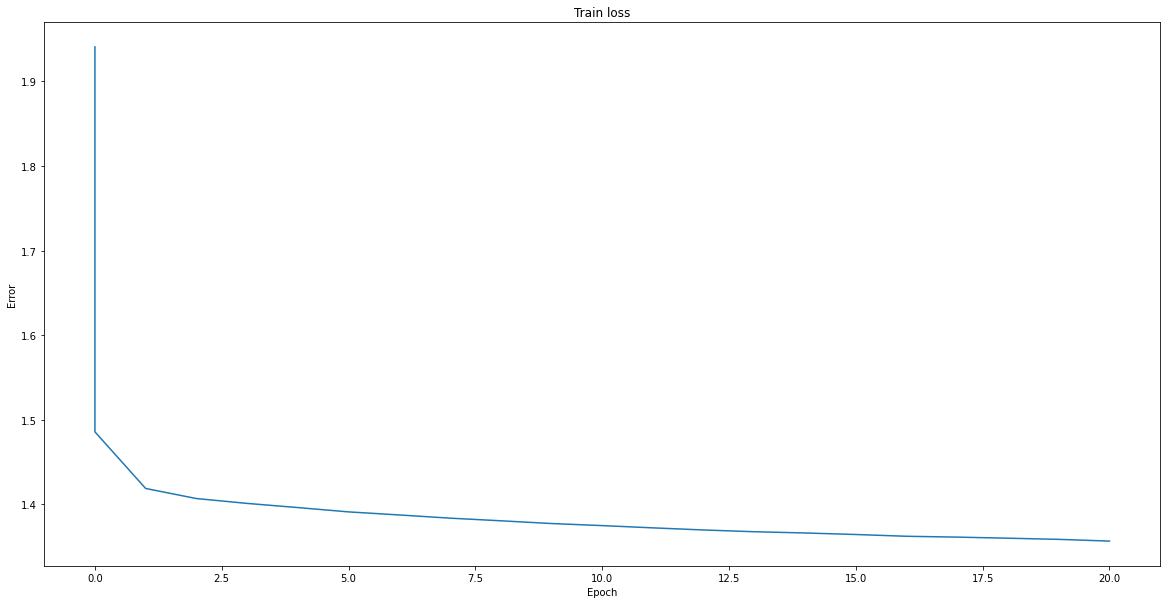

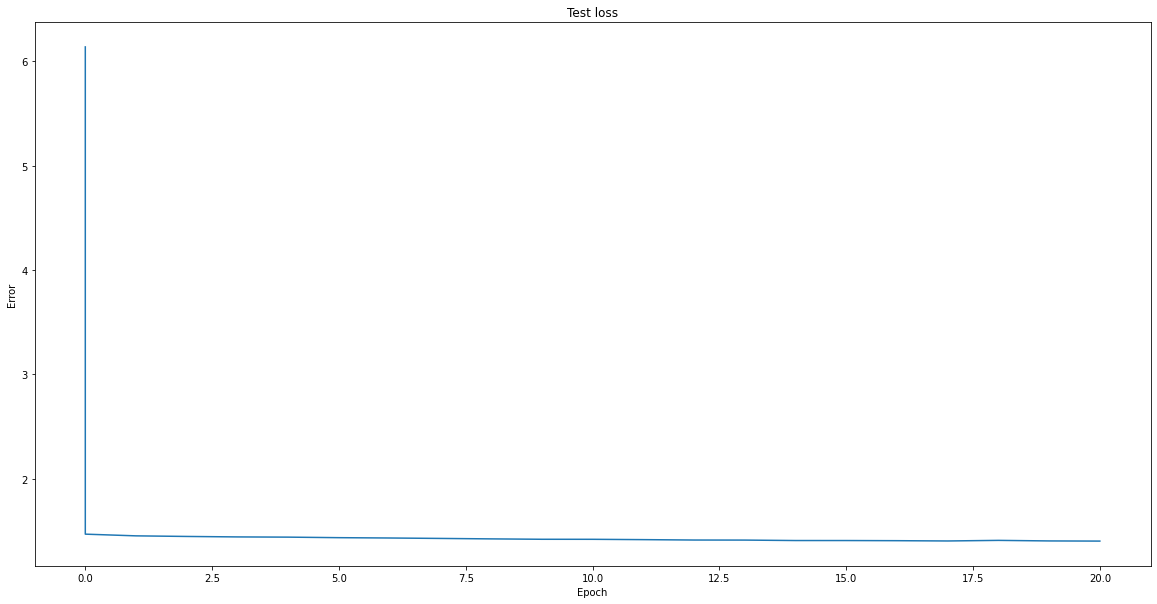

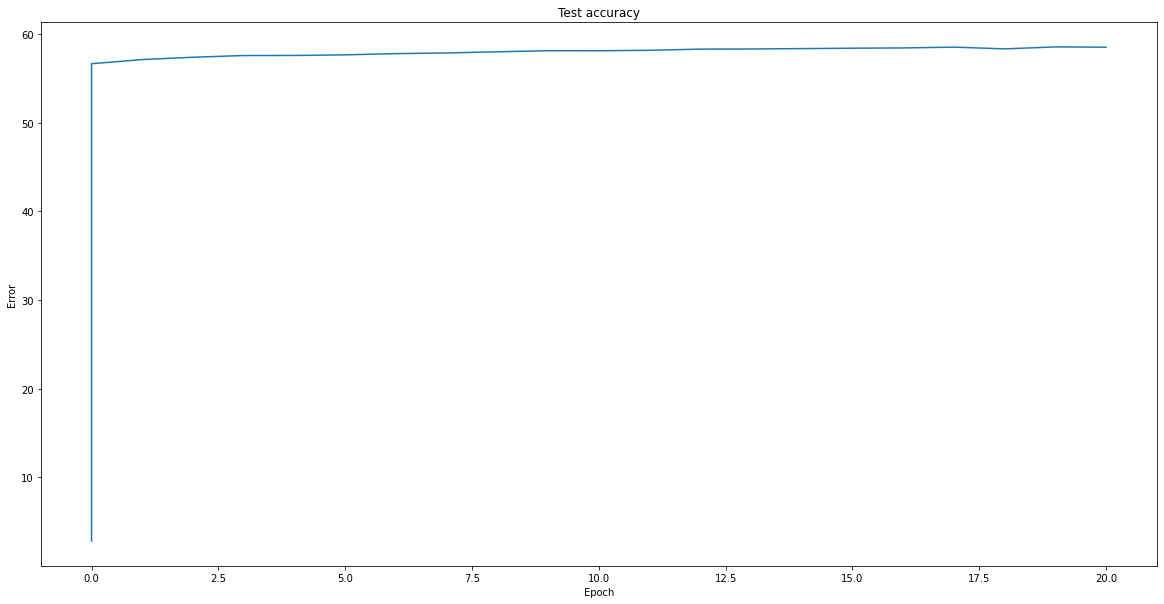

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet2(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            # train_perplexity.append((epoch, math.exp(train_loss)))
            # test_perplexity.append((epoch, math.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        # ep, val = zip(*train_perplexity)
        # pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        # ep, val = zip(*test_perplexity)
        # pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    